# AFM DASHBOARD

## Load libraries


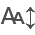

In [1]:
# %load_ext autoreload
# %autoreload 2
# %matplotlib widget
# %matplotlib inline
# %matplotlib agg

import ipywidgets as widgets
import numpy as np
import matplotlib.pyplot as plt
# import matplotlib
# matplotlib.interactive(False)
import seaborn as sns
import os
import datetime
import itables
from itables import init_notebook_mode
from sklearn.cluster import KMeans
from IPython.display import display, HTML, clear_output
from tkinter import filedialog

from wsxm_read import *
from wsxm_analyze import *

init_notebook_mode(all_interactive=True)

## FILE BROWSER

In [2]:
# folderpath = filedialog.askdirectory() #use folder picker dialogbox
folderpath = '/home/pranav/Work/Data/Murcia/AFM/20240412 thiol interdigielec Sitip old'
# folderpath = 'data'
print(f'Data folder: {folderpath}')

#create folder to save dashboard output files in
outputpath = f'{folderpath}/dashboard output'
os.makedirs(outputpath, exist_ok=True)

#creates data file list contained within the folder as "datalist.pkl" & "datalist.xlsx"
#Set refresh=True to recreate file list again, else set to False to use previously created file list/create one if it doesn't exist
file_df = wsxm_collect_files(folderpath, refresh=False)



#File Viewer Dashboard

data_type_button = widgets.ToggleButtons(options=['all','1D', '2D', '3D'],
                                         disabled=False)
chans_list = list(file_df['channel'].unique())
channel_view_select = widgets.SelectMultiple(options=chans_list, 
                                             value=['Topography' if 'Topography' in chans_list else chans_list[0]],
                                             description='channels', diabled=False)
table_type_button = widgets.ToggleButtons(options=['full', 'summary'],
                                         disabled=False)
data_type_button.value = '2D'
dash0_output = widgets.Output()
dash0_box1 = widgets.HBox([data_type_button, channel_view_select])

# @dash0_output.capture()
def dash0_update_summarytable(change):
    table_type = table_type_button.value
    if table_type == 'summary':
        view_channels = list(channel_view_select.value) #['Topography', 'Normal force', 'Excitation frequency', 'Adhesion']
        type = data_type_button.value
        df_list = []
        for key in file_df['file'].unique():
            for chan in view_channels:
                if type == 'all':
                    file_df_filter = file_df.loc[(file_df.file==key) & (file_df.channel==chan)]
                else:
                    file_df_filter = file_df.loc[(file_df.type==type) & (file_df.file==key) & (file_df.channel==chan)]
                if file_df_filter.size!=0:                    
                    df_list.append(file_df_filter.sort_values(by=['name'], ascending=False).iloc[0]) #first file (forward dir)
        if len(df_list) == 0:
            dash0_output.clear_output()
        else:
            file_df2 = pd.concat(df_list, axis=1).transpose()
            column_group = ['file', 'type', 'size','resolution', 'feedback']
            file_df_pivot = file_df2.pivot_table(columns='channel', values='plot', 
                                                  index=column_group,
                                                 aggfunc='min').reset_index()
            file_df_mintime = file_df2.groupby(column_group)['time'].min().reset_index()
            file_df_summary = pd.merge(file_df_pivot, file_df_mintime, on=column_group)
            file_df_summary = file_df_summary.reindex(['file'] + view_channels + ['size', 'resolution', 'feedback', 'time'], axis=1)
            file_df_summary.sort_values(by=['file'], inplace=True)
            file_df_summary.dropna(inplace=True) #only show rows which contain images of all selected channels
            dash0_output.clear_output()
            with dash0_output:
                itables.show(file_df_summary)

# @dash0_output.capture()
def dash0_update_tabletype(change):
    table_type = change.new
    if table_type == 'full':
        dash0_output.clear_output()
        with dash0_output:
            itables.show(file_df, column_filters = "header", layout={"topEnd": None})
        dash0_box1.layout.display='none'
    if table_type == 'summary':
        dash0_update_summarytable(None)
        dash0_box1.layout.display=None

data_type_button.observe(dash0_update_summarytable, 'value')
channel_view_select.observe(dash0_update_summarytable, 'value')
table_type_button.observe(dash0_update_tabletype, 'value')

display(table_type_button)
display(dash0_box1)
display(dash0_output)
table_type_button.value = 'summary'
# dash0_update_summarytable(None)
# with dash0_output:
#     itables.show(file_df, column_filters = "header", layout={"topEnd": None})
# box1.layout.display='none'


Data folder: /home/pranav/Work/Data/Murcia/AFM/20240412 thiol interdigielec Sitip old


ToggleButtons(options=('full', 'summary'), value='full')

Output()

## AFM CALIBRATION

### Thermal noise method

SOME RAW DATA NOT IN VOLTS! Skipped: thermalcalib_laseroff_0000; thermalcalib_laseroff_0001; thermalcalib_laseroff_0002; thermalcalib_laseroff_0003; thermalcalib_laseroff_0004; thermalcalib_laseroff_0005; thermalcalib_laseroff_0006; thermalcalib_laseron_0000; thermalcalib_laseron_0001; thermalcalib_laseron_0002; thermalcalib_laseron_0003; thermalcalib_laseron_0004



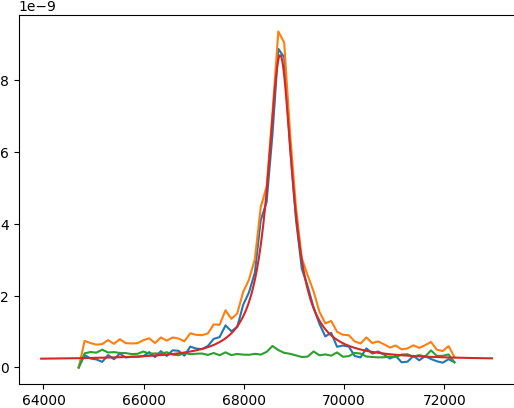
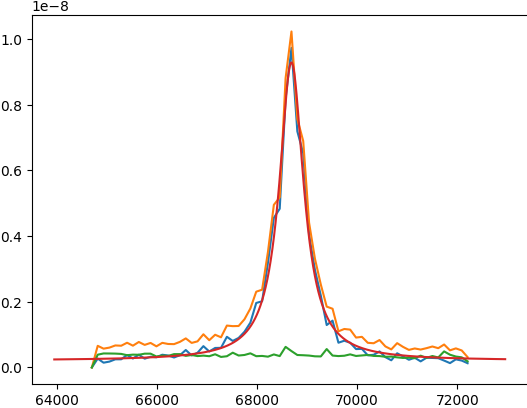
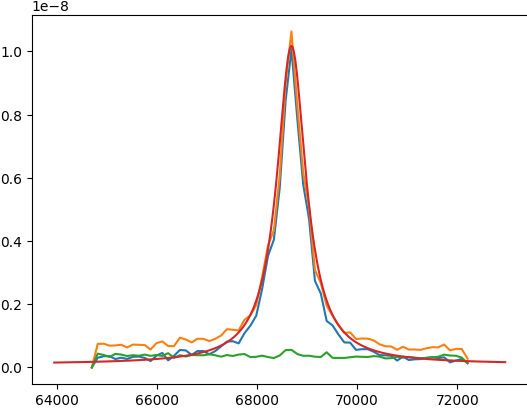
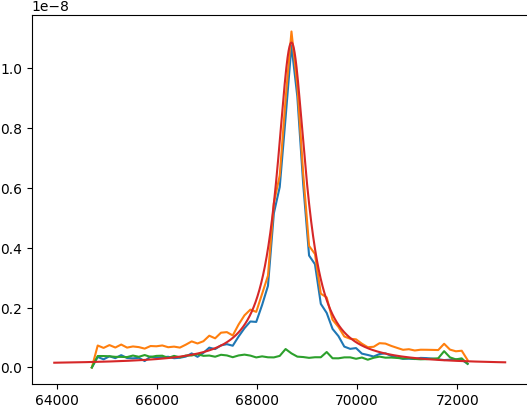
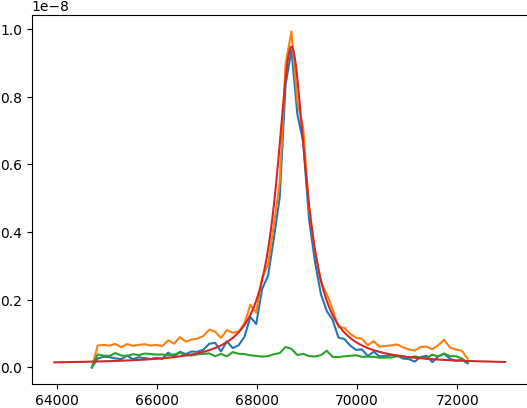

In [3]:
#Calibrate Amplitude in nm/V from thermal noise images (laser on/off)

# files = ['thermalcalib_laseroff_0000', 'thermalcalib_laseroff_0001', 'thermalcalib_laseroff_0002','thermalcalib_laseroff_0003', 'thermalcalib_laseroff_0004',
#         'thermalcalib_laseron_0000', 'thermalcalib_laseron_0001', 'thermalcalib_laseron_0002', 'thermalcalib_laseron_0003', 'thermalcalib_laseron_0004']
file_paths = list(filedialog.askopenfilenames(title='Choose thermal noise image files', 
                                              initialdir=folderpath, filetypes=(('amplitude channel', '*.ch15'),)))
file_keys = []
for file_path_i in file_paths: #find the list of unique file keyword names
    file_name_i = os.path.basename(file_path_i)
    file_keys.append(file_df[file_df['name']==file_name_i]['file'].iloc[0])
files = list(dict.fromkeys(file_keys))

chan = 'Amplitude'
chan_dir = 'Forward'

calib_data_dict = {'plot': [], 'file':[], 'direction':[], 'frequency':[], 'psd':[], 'psd max':[], 'zrms':[], 'gain in':[]}
files_skipped = []
for file_i in files:
    filepath_i = folderpath + '/' + file_df.loc[(file_df.file==file_i)].iloc[0].loc['name']
    data_i = wsxm_readchan(filepath_i, all_files=True, mute=True)
    for chan_dir in data_i[chan].keys():
        chan_data_i = data_i[chan][chan_dir]
        if chan_data_i['header']['Z Amplitude'].split(' ')[1] != 'V':
            files_skipped.append(file_i)
            # print('RAW DATA NOT IN VOLTS! Skipping:', file_i, chan, chan_dir)
            continue
        freq_i, psd_i, psdmax_i, zrms_i, fig_i = get_psd_calib(chan_data_i)
        calib_data_dict['file'].append(file_i)
        calib_data_dict['direction'].append(chan_dir)
        calib_data_dict['frequency'].append(freq_i)
        calib_data_dict['psd'].append(psd_i)
        calib_data_dict['psd max'].append(psdmax_i)
        calib_data_dict['zrms'].append(zrms_i)
        calib_data_dict['plot'].append(fig_i)
        calib_data_dict['gain in'].append(int(chan_data_i['header']['Gain in']))
        
calib_df = pd.DataFrame(calib_data_dict)

#assort files into "laser on" and "laser off" groups using kmeans clustering algo on max of psd value
rms_values = calib_df['psd max'].values.reshape(-1,1)
kmeans = KMeans(n_clusters=2) # Create a KMeans instance with 2 clusters: kmeans
kmeans.fit(rms_values) # Fit model to your data
centroids = kmeans.cluster_centers_# Get the cluster centroids
low_cluster, high_cluster = (0, 1) if centroids[0] < centroids[1] else (1, 0) # Determine which cluster corresponds to 'low' or 'high'
calib_df['Laser'] = ['OFF' if label == low_cluster else 'ON' for label in kmeans.labels_]
calib_df_off = calib_df[calib_df['Laser'] == 'OFF'].reset_index(drop=True)
calib_df_on = calib_df[calib_df['Laser'] == 'ON'].reset_index(drop=True)
row_min = min([calib_df_on.shape[0],calib_df_off.shape[0]]) #for one-to-one map of ON and OFF files

calib_result_dict = {'Amplitude calib':[], 'Spring constant':[], 'Q factor':[], 'Amp rms':[], 
                     'gain in':[], 'file_on': [], 'file_off': [], 'plot': []}
for i in range(row_min):
    ampcali_i, kcant_i, qfac_i, amprms_i, plot_i = get_calib(calib_df_on,calib_df_off,i)
    calib_result_dict['Amplitude calib'].append(ampcali_i)
    calib_result_dict['Spring constant'].append(kcant_i)
    calib_result_dict['Q factor'].append(qfac_i)
    calib_result_dict['Amp rms'].append(amprms_i)
    calib_result_dict['plot'].append(plot_i)
    calib_result_dict['gain in'].append(calib_df_on['gain in'].iloc[i])
    calib_result_dict['file_on'].append(calib_df_on['file'].iloc[i])
    calib_result_dict['file_off'].append(calib_df_off['file'].iloc[i])
calib_result_df = pd.DataFrame(calib_result_dict)


calib_summary = pd.DataFrame({'Mean': calib_result_df.drop(columns=['plot', 'gain in','file_on','file_off']).mean(),
                              'Standard Deviation': calib_result_df.drop(columns=['plot', 'gain in', 'file_on', 'file_off']).std()
                              })

#set calibration dictionary
CALIB_DICT['Amplitude']['nm']['factor'] = calib_summary['Mean'].loc['Amplitude calib']

if len(files_skipped) != 0:
    print('SOME RAW DATA NOT IN VOLTS! Skipped:', '; '.join(files_skipped))
itables.show(calib_summary)
itables.show(calib_result_df)
# itables.show(calib_df.drop(columns=['frequency', 'psd']))

### Force-distance method


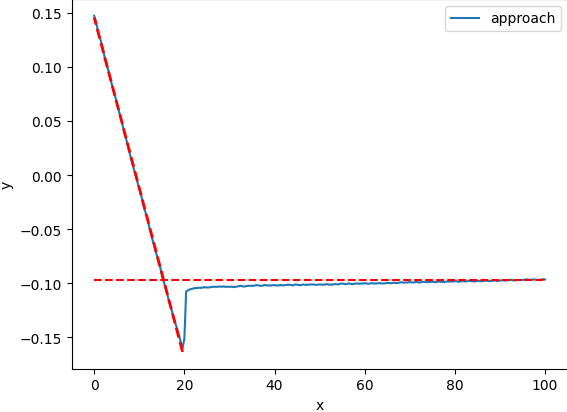
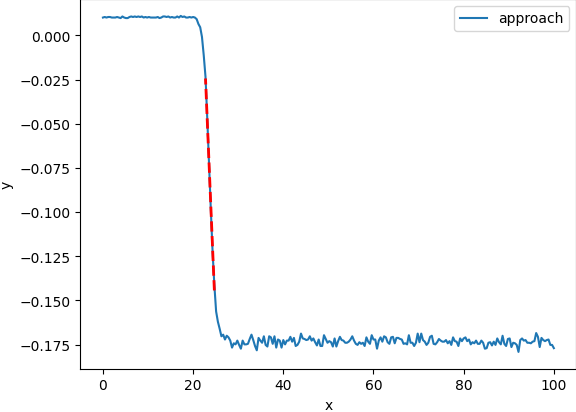
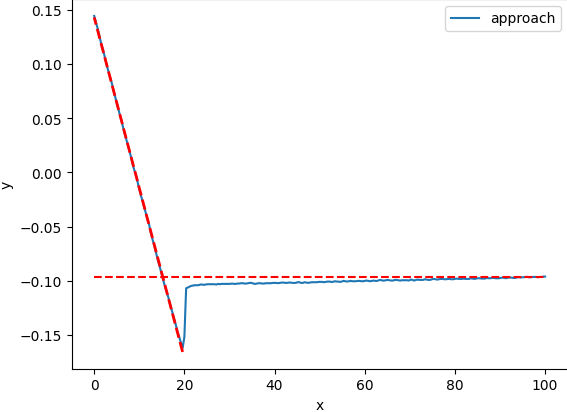
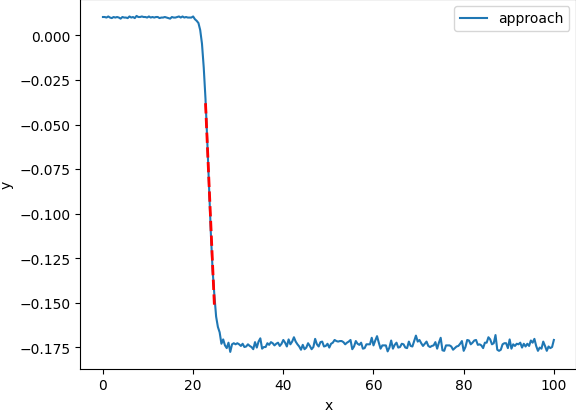
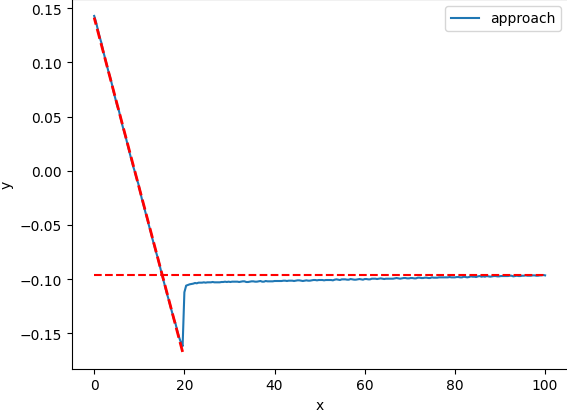
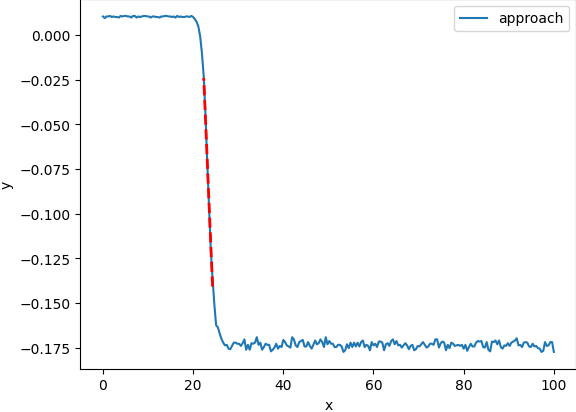
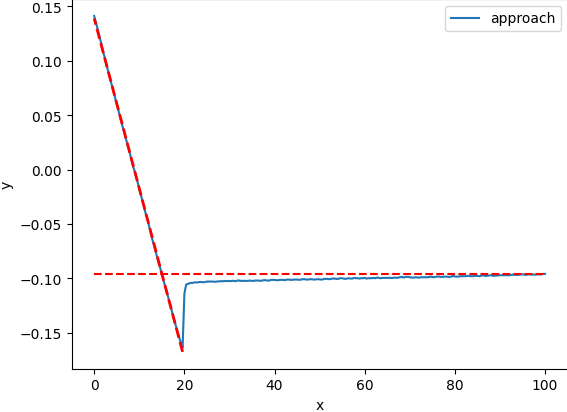
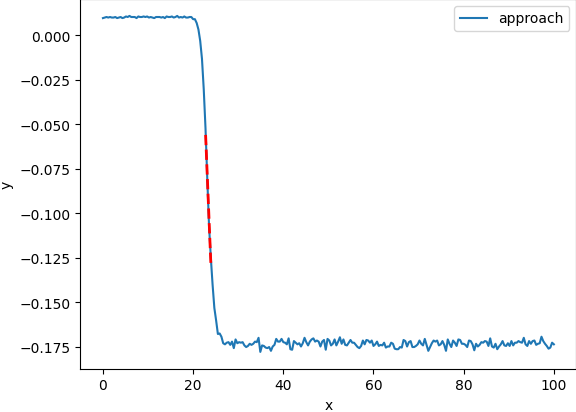
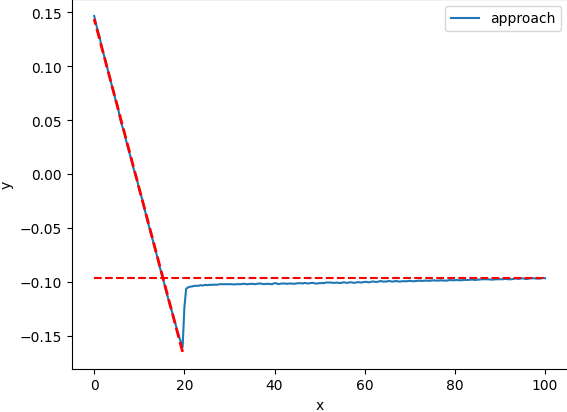
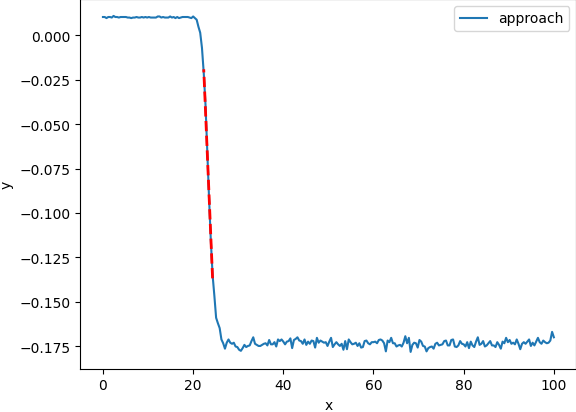
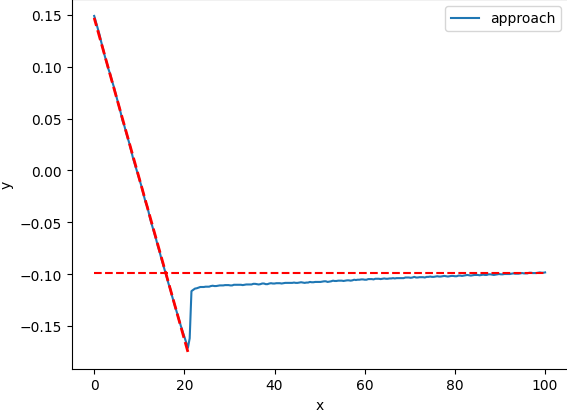
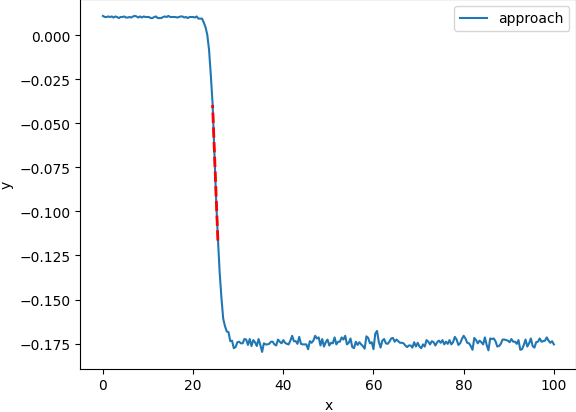
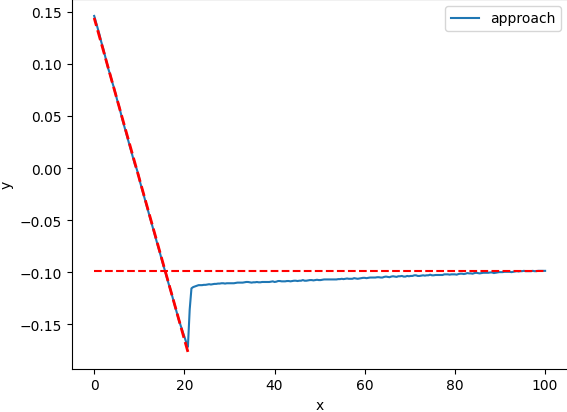
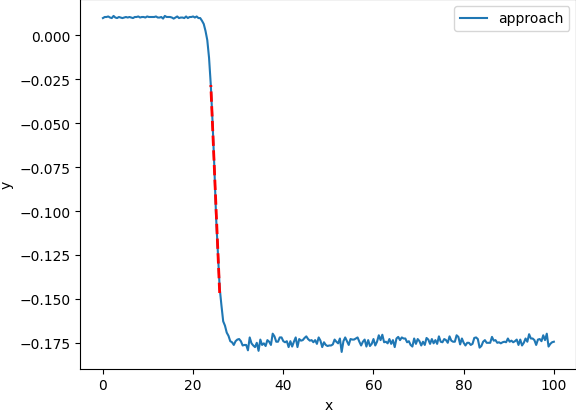
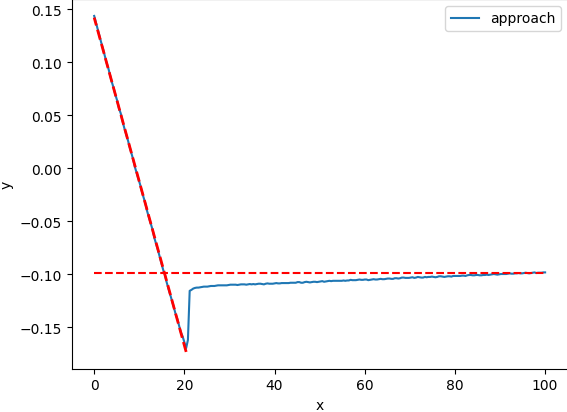
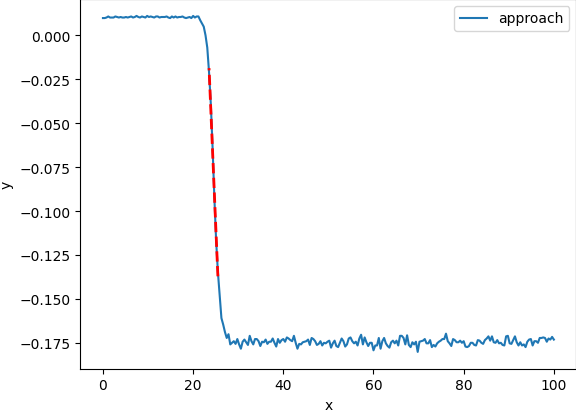
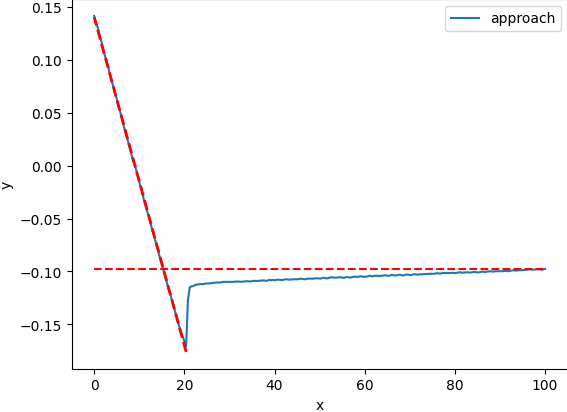
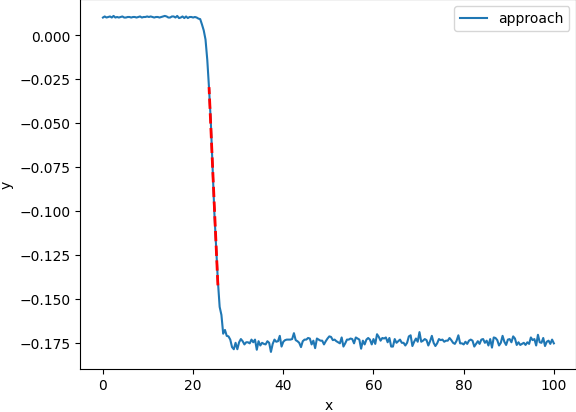
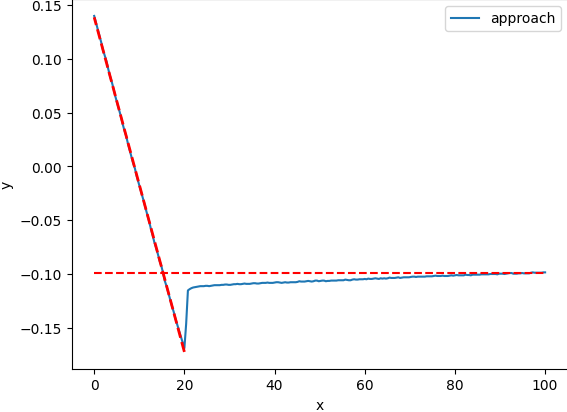
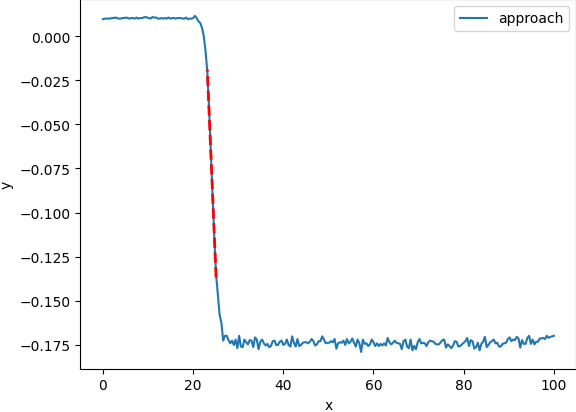
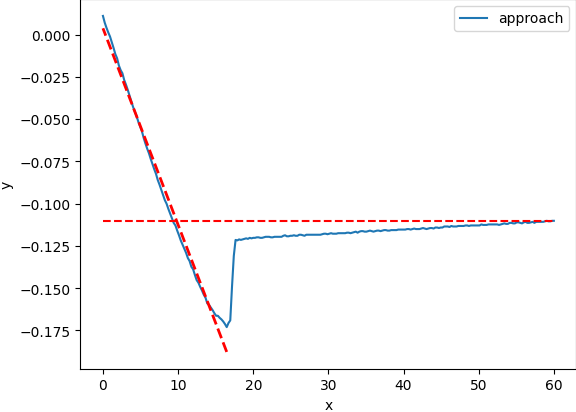
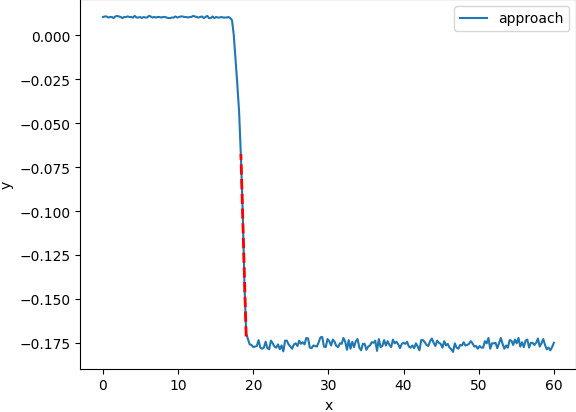
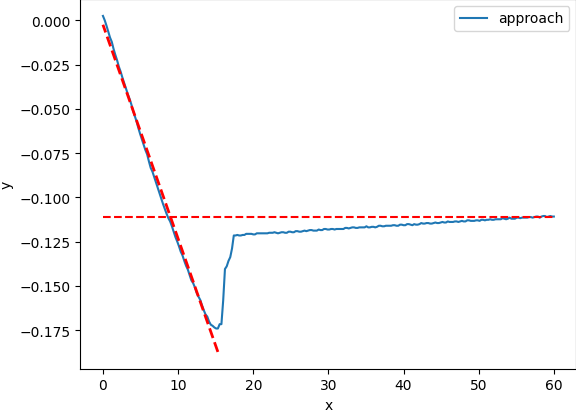
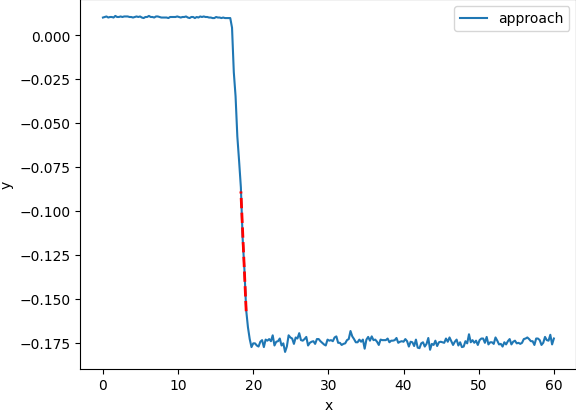
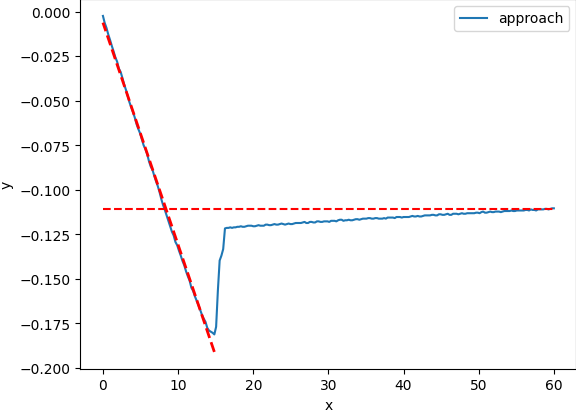
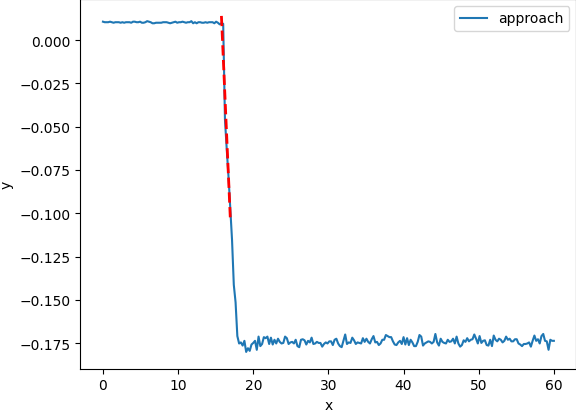
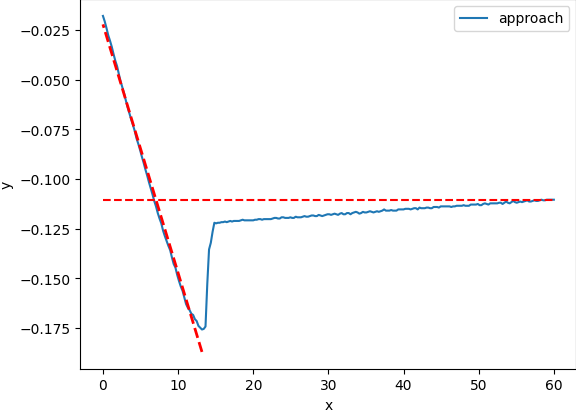
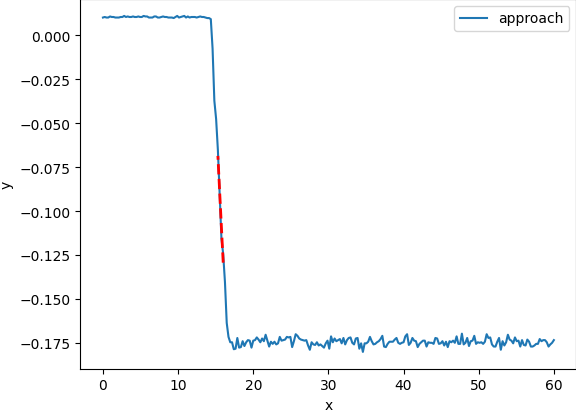
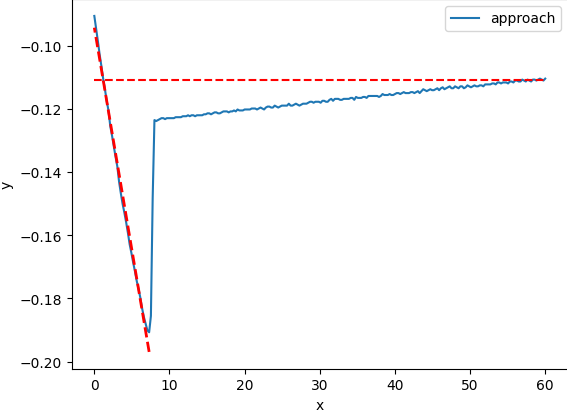
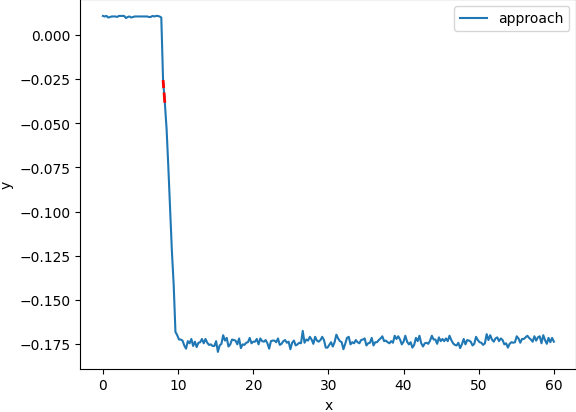
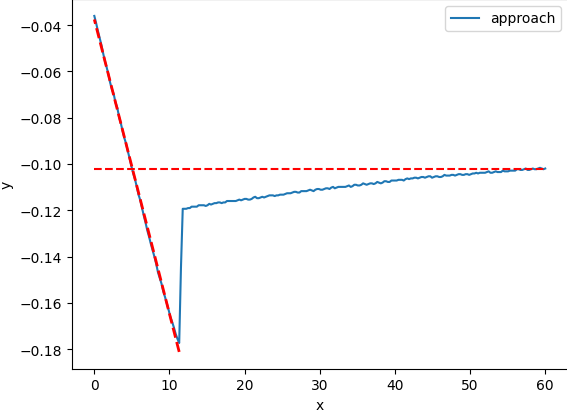
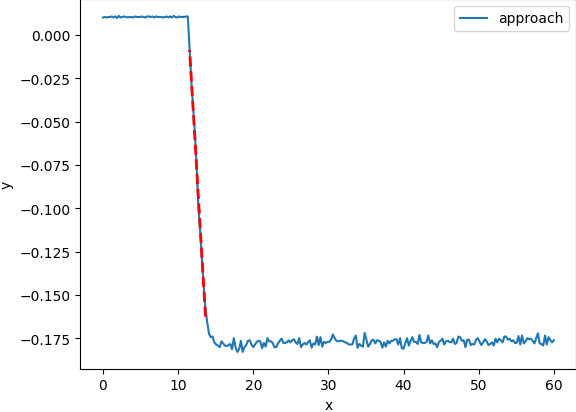
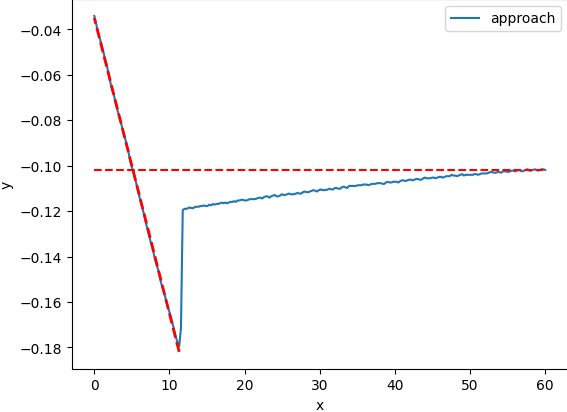
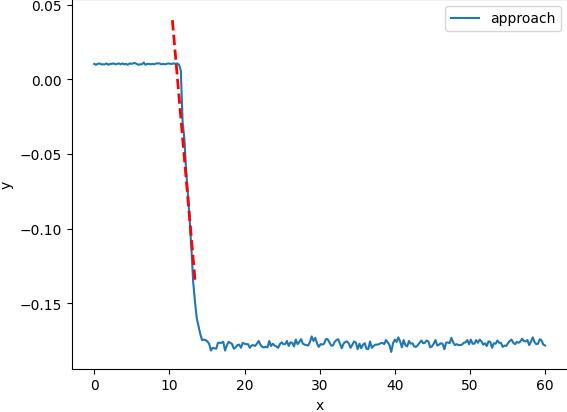
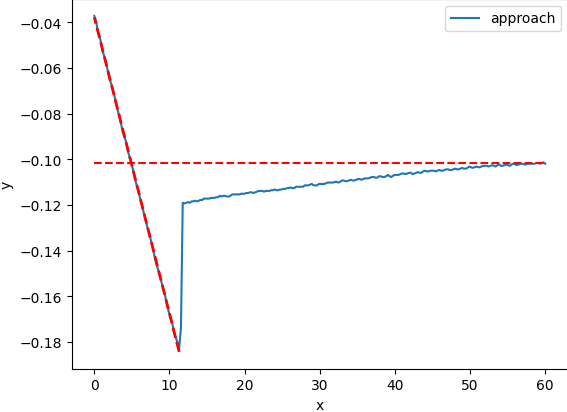
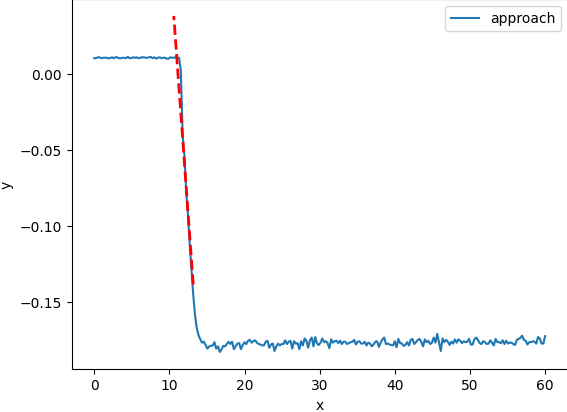
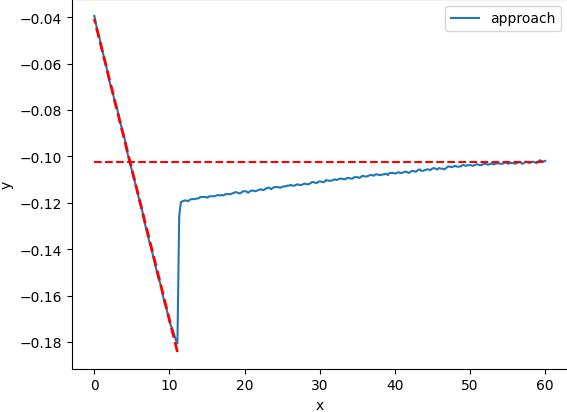
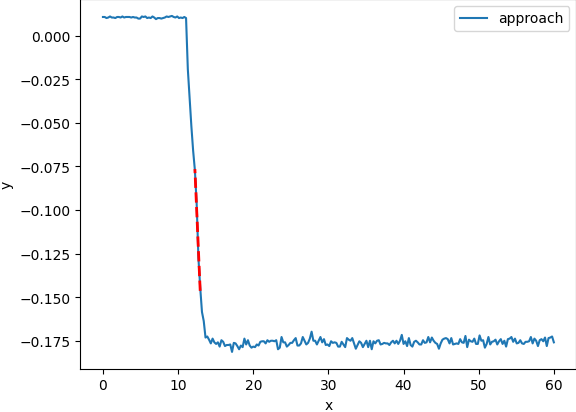
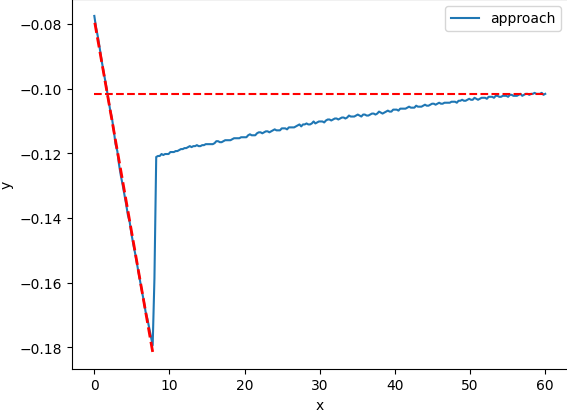
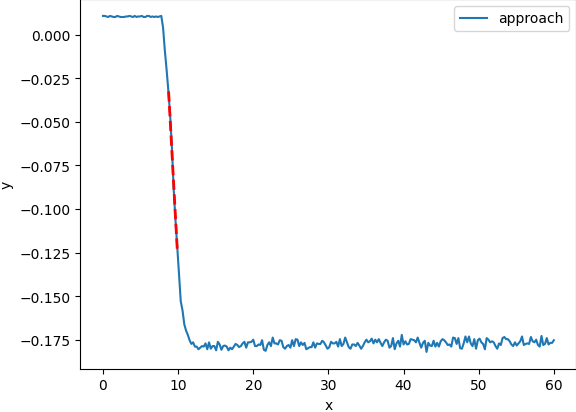

In [4]:
#Calibrate normal force and amplitude from spectroscopy curves

file_paths = list(filedialog.askopenfilenames(title='Choose spectroscopy file', 
                                              initialdir=folderpath, filetypes=(('spectroscopy data',['*.curves','*.cur','*.stp','*.curve']),)))
file_keys = []
for file_path_i in file_paths: #find the list of unique file keyword names
    file_name_i = os.path.basename(file_path_i)
    file_keys.append(file_df[file_df['name']==file_name_i]['file'].iloc[0])
files = list(dict.fromkeys(file_keys))
# files = ['interdigThiols_tipSi3nN_a_0003', 'interdigThiols_tipSi3nN_a_0005']

# chan = 'Normal force'
spec_dir = 'approach'

calib_spectro_dict = {'normal force calib':[], 'amplitude calib':[], 'file':[], 'curve num':[], 'plot normf': [], 'plot amp': []}
for file_i in files:
    filepath_i = folderpath + '/' + file_df.loc[(file_df.file==file_i)].iloc[0].loc['name']
    # filename_i = os.path.basename(filepath_i)
    data_i = wsxm_readspectra(filepath_i, all_files=True, mute=True)
    # for chan_dir in data_i[chan].keys():
    curve_numlist = data_i['Normal force']['curves'].keys()
    for curv_ind in curve_numlist:
        spectro_data_i = data_i['Normal force']['curves'][curv_ind]['data']
        #normal force calibration
        spectrodf_i, spectroparam_i = wsxm_calcspectroparam(spectro_data_i, 'Normal force', unit='V')
        if spectroparam_i['Stiffness']['value'] != 0:
            defl_calib = 1/spectroparam_i['Stiffness']['value'] #cantilever deflection calibration in nm/V
        else:
            defl_calib = 0
            print('Normal force slope is zero. Check: ', file_i)
        fig, ax = plt.subplots()
        sns.lineplot(data=spectrodf_i[spectrodf_i['segment'] == spec_dir], x="x", y="y", hue="segment", ax=ax)
        handles, labels = ax.get_legend_handles_labels()
        ax.legend(handles=handles, labels=labels) #remove legend title        
        ax.hlines(spectroparam_i['Adhesion']['zero'], spectrodf_i['x'].min(), 
                   spectrodf_i['x'].max(), linestyles='dashed', colors='r')
        ax.plot(spectroparam_i['Stiffness']['x'], spectroparam_i['Stiffness']['y'],
                 'r', linestyle='dashed',linewidth=2)
        fig_i = fig2html(fig, size=200)
        plt.close()
        calib_spectro_dict['normal force calib'].append(defl_calib)
        calib_spectro_dict['plot normf'].append(fig_i)
        
        #amplitude calibration
        spectro_data_i = data_i['Amplitude']['curves'][curv_ind]['data']
        spectrodf_i, spectroparam_i = wsxm_calcspectroparam(spectro_data_i, 'Amplitude', unit='V')
        if spectroparam_i['Slope-amp']['value'] != 0:
            amp_calib = 1/spectroparam_i['Slope-amp']['value'] #amplitude calibration in nm/V
        else:
            amp_calib = 0
            print('Amp slope is zero. Check: ', file_i)
        fig, ax = plt.subplots()
        sns.lineplot(data=spectrodf_i[spectrodf_i['segment'] == spec_dir], x="x", y="y", hue="segment", ax=ax)
        handles, labels = ax.get_legend_handles_labels()
        ax.legend(handles=handles, labels=labels) #remove legend title        
        ax.plot(spectroparam_i['Slope-amp']['x'], spectroparam_i['Slope-amp']['y'],
                 'r', linestyle='dashed',linewidth=2)
        fig_i = fig2html(fig, size=200)
        plt.close()
        calib_spectro_dict['amplitude calib'].append(amp_calib)
        calib_spectro_dict['plot amp'].append(fig_i)
        
        calib_spectro_dict['file'].append(file_i)
        calib_spectro_dict['curve num'].append(curv_ind)
        

calib_spectro_df = pd.DataFrame(calib_spectro_dict)

calib_spectro_summary = pd.DataFrame({'Mean': calib_spectro_df[['normal force calib', 'amplitude calib']].mean(),
                                      'Standard Deviation': calib_spectro_df[['normal force calib', 'amplitude calib']].std()
                                      })
#set calibration dictionary
#COMMENT IF YOU DONT WANT TO USE AMPLITUDE CALIBRATION FROM SPECTROSCOPY FIT
CALIB_DICT['Amplitude']['nm']['factor'] = calib_spectro_summary['Mean'].loc['amplitude calib']

CALIB_DICT['Normal force']['nm']['factor'] = calib_spectro_summary['Mean'].loc['normal force calib']
CALIB_DICT['Normal force']['nN']['factor'] = calib_spectro_summary['Mean'].loc['normal force calib']*calib_summary['Mean'].loc['Spring constant']
# print(CALIB_DICT)
itables.show(calib_spectro_summary)
itables.show(calib_spectro_df)

## FORCE-VOLUME ANALYSIS

### Load data

In [3]:
#Load WSxM force-volume data file
#filepath = 'data/20240202_laser_off_128pts_58lps_0002.f.dy.ch15'
#filepath = 'data/interdigThiols_tipSi3nN_b_0026.f.dy.top'
# filepath = 'data/interdigThiols_tipSi3nN_b_0026.fb.ch1.gsi' #ff,fb,bb,bf:1st letter=x dir,2nd letter=z dir
#filepath = 'data/interdigThiols_tipSi3nN_b_0023_Excitation frequency.f.curves'

filekey = 'interdigThiols_tipSi3nN_b_0026' #common part of file name
filepath = folderpath + '/' + file_df.loc[(file_df.file==filekey)].iloc[0].loc['name']

data_dict = wsxm_readforcevol(filepath, all_files=True, topo_only=False) #complete force volume data with all channels

#prepare and initialize data for dashboards

chan_list = list(data_dict.keys())
chan_list.remove('Topography') #only include 3d data in channel list
channel = chan_list[0] #'Excitation frequency', 'Normal force', 'Amplitude', 'Topography'
img_dir = 'Forward' # 'Forward', 'Backward'
param_data_dict = calc_spectro_prop(data_dict, channel, img_dir)

header_dict = data_dict[channel][f'Image {img_dir} with Forward Ramps']['header']
x_num = int(header_dict['Number of rows'])
y_num = int(header_dict['Number of columns'])
z_num = int(header_dict['Number of points per ramp'])
x_data = data_dict[channel][f'Image {img_dir} with Forward Ramps']['data']['X']
y_data = data_dict[channel][f'Image {img_dir} with Forward Ramps']['data']['Y']
z_data = data_dict[channel][f'Image {img_dir} with Forward Ramps']['data']['Z']
param_list = list(param_data_dict.keys()) #all calculated parameter images eg. adhesion
param_list.insert(0,'Topography')

#calculate global channel mins and maxs
chan_mins, chan_maxs = {}, {}
for chan_i in data_dict.keys():
    min_temp, max_temp = [], []
    for dir_i in data_dict[chan_i].keys():
        z_lab_i = 'Z' if chan_i == 'Topography' else 'ZZ'
        min_temp.append(data_dict[chan_i][dir_i]['data'][z_lab_i].min())
        max_temp.append(data_dict[chan_i][dir_i]['data'][z_lab_i].max())
    chan_mins[chan_i] = min(min_temp)
    chan_maxs[chan_i] = max(max_temp)

#mins and maxs of x,y,z arrays
xmin, xmax = x_data.min(), x_data.max()
ymin, ymax = y_data.min(), y_data.max()
zmin, zmax = z_data.min(), z_data.max()
# #spectroscopy
# spectro_data = wsxm_getspectro(data_dict, channel=channel, img_dir=img_dir)
# df_spectro, data_param = wsxm_calcspectroparam(spectro_data, channel)

1 interdigThiols_tipSi3nN_b_0026.bf.ch12.gsi
2 interdigThiols_tipSi3nN_b_0026.fb.ch12.gsi
3 interdigThiols_tipSi3nN_b_0026.ff.ch12.gsi
4 interdigThiols_tipSi3nN_b_0026.ff.ch1.gsi
5 interdigThiols_tipSi3nN_b_0026.bb.ch1.gsi
6 interdigThiols_tipSi3nN_b_0026.bb.ch15.gsi
7 interdigThiols_tipSi3nN_b_0026.ff.ch15.gsi
8 interdigThiols_tipSi3nN_b_0026.fb.ch15.gsi
9 interdigThiols_tipSi3nN_b_0026.bb.ch12.gsi
10 interdigThiols_tipSi3nN_b_0026.bf.ch15.gsi
11 interdigThiols_tipSi3nN_b_0026.bf.ch1.gsi
12 interdigThiols_tipSi3nN_b_0026.fb.ch1.gsi


### Data viewer

Output()

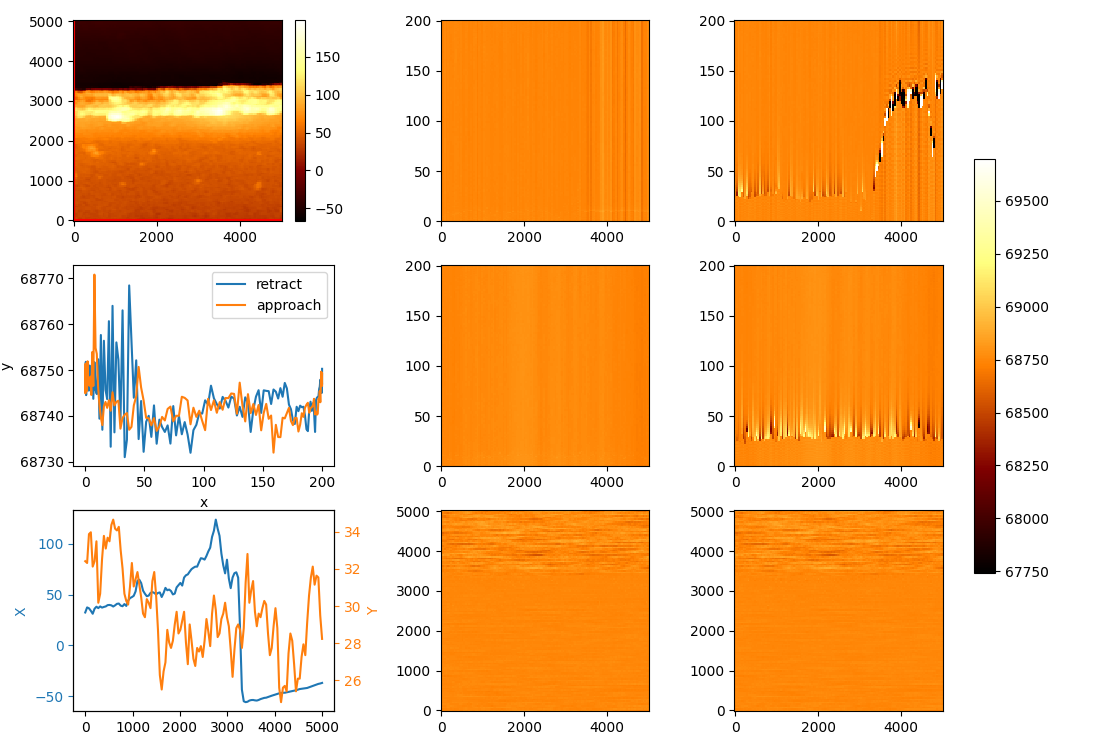

In [9]:
#close dashboard-1 figure if already open
for fignum_i in plt.get_fignums():
    figlab_i = plt.figure(fignum_i).get_label()
    if figlab_i == 'dash1':
        plt.close(figlab_i) 
    
fig, ax = plt.subplots(3,3, figsize=(11,7.5), num='dash1')#, layout='constrained')
fig.canvas.header_visible = False
fig.canvas.toolbar_position = 'bottom'

channel = chan_list[0] #'Excitation frequency', 'Normal force', 'Amplitude', 'Topography'
img_dir = 'Forward' # 'Forward', 'Backward'

#topography
xx, yy, zz = get_imgdata(data_dict['Topography'][f'Image {img_dir} with Forward Ramps'])
pmesh_top = ax[0][0].pcolormesh(xx,yy,zz, cmap='afmhot',vmin=chan_mins['Topography'],
                                vmax=chan_maxs['Topography'])
cb_top = plt.colorbar(pmesh_top, ax=ax[0][0])
#topgraphy lines
color_list = sns.color_palette()
xx, yy = get_imgline(data_dict['Topography'][f'Image {img_dir} with Forward Ramps'],x=xmin)
line_top_x = ax[2][0].plot(xx,yy,color=color_list[0]) #vertical
ax_top_y = ax[2][0].twinx()
xx, yy = get_imgline(data_dict['Topography'][f'Image {img_dir} with Forward Ramps'],y=ymin)
line_top_y = ax_top_y.plot(xx,yy,color=color_list[1]) #horizontal
ax[2][0].set_ylabel('X')
ax[2][0].yaxis.label.set_color(color_list[0])
ax[2][0].tick_params(axis='y', colors=color_list[0]) 
ax_top_y.set_ylabel('Y')
ax_top_y.yaxis.label.set_color(color_list[1])
ax_top_y.tick_params(axis='y', colors=color_list[1]) 

#XZ section images
xx, yy, zz = get_imgdata(data_dict[channel][f'Image {img_dir} with Forward Ramps'], 'XZ')
pmesh_xz_a = ax[1][1].pcolormesh(xx,yy,zz, cmap='afmhot',vmin=chan_mins[channel], 
                                 vmax=chan_maxs[channel]) #approach
xx, yy, zz = get_imgdata(data_dict[channel][f'Image {img_dir} with Backward Ramps'], 'XZ')
pmesh_xz_r = ax[1][2].pcolormesh(xx,yy,zz, cmap='afmhot',vmin=chan_mins[channel], 
                                 vmax=chan_maxs[channel]) #retract
#YZ section images
xx, yy, zz = get_imgdata(data_dict[channel][f'Image {img_dir} with Forward Ramps'], 'YZ')
pmesh_yz_a = ax[0][1].pcolormesh(xx,yy,zz, cmap='afmhot',vmin=chan_mins[channel], 
                                 vmax=chan_maxs[channel]) #approach
xx, yy, zz = get_imgdata(data_dict[channel][f'Image {img_dir} with Backward Ramps'], 'YZ')
pmesh_yz_r = ax[0][2].pcolormesh(xx,yy,zz, cmap='afmhot',vmin=chan_mins[channel], 
                                 vmax=chan_maxs[channel]) #retract
#XY section images
xx, yy, zz = get_imgdata(data_dict[channel][f'Image {img_dir} with Forward Ramps'], 'XY')
pmesh_xy_a = ax[2][1].pcolormesh(xx,yy,zz, cmap='afmhot',vmin=chan_mins[channel], 
                                 vmax=chan_maxs[channel]) #approach
xx, yy, zz = get_imgdata(data_dict[channel][f'Image {img_dir} with Backward Ramps'], 'XY')
pmesh_xy_r = ax[2][2].pcolormesh(xx,yy,zz, cmap='afmhot',vmin=chan_mins[channel], 
                                 vmax=chan_maxs[channel]) #retract

plt.tight_layout()
cb_chan = plt.colorbar(pmesh_xz_r, ax=[ax[0][1], ax[1][1], ax[2][1], ax[0][2], ax[1][2], ax[2][2]],
                      shrink=0.6)

#spectroscopy
spectro_data = wsxm_getspectro(data_dict, channel=channel, img_dir=img_dir)
df_spectro, data_param = wsxm_calcspectroparam(spectro_data, channel)
line_spec = sns.lineplot(data=df_spectro, x="x", y="y", hue="segment", ax=ax[1][0])
handles, labels = ax[1][0].get_legend_handles_labels()
leg = ax[1][0].legend(handles=handles, labels=labels)
leg.set_draggable(True)
#position lines on topo
line_h = ax[0][0].axhline(ymin, xmin, xmax, linestyle='solid', color='r')
line_v = ax[0][0].axvline(xmin, ymin, ymax, linestyle='solid', color='r')

#widgets
slide_x = widgets.IntSlider(value=xmin, min=xmin, max=xmax, step=(xmax-xmin)/x_num,
                            description='x')
slide_y = widgets.IntSlider(value=ymin, min=ymin, max=ymax, step=(ymax-ymin)/y_num,
                            description='y')
slide_z = widgets.IntSlider(value=zmin, min=zmin, max=zmax, step=(zmax-zmin)/z_num,
                            description='z')
slide_zrange = widgets.IntSlider(value=zmax, min=zmin, max=zmax, step=(zmax-zmin)/z_num,
                            description='z limit')
slide_cb = widgets.FloatRangeSlider(value=[chan_mins[channel], chan_maxs[channel]], 
                                    min=chan_mins[channel], max=chan_maxs[channel], 
                                    step=(chan_maxs[channel]-chan_mins[channel])/100,
                                    description='color',readout=True)
chan_button = widgets.ToggleButtons(options=chan_list,
                                    # description='Channel:',
                                     disabled=False)
imgdir_button = widgets.ToggleButtons(options=['Forward', 'Backward'],
                                    # description='Channel:',
                                     disabled=False)
param_dropdown = widgets.Dropdown(options=param_list,
                                  value='Topography',disabled=False)
output = widgets.Output()
box1 = widgets.VBox([slide_x, slide_y, slide_z, slide_zrange, slide_cb])
box2 = widgets.VBox([param_dropdown, imgdir_button])
box3 = widgets.VBox([chan_button])

#update functions

@output.capture()
def update_x(change):
    img_dir = imgdir_button.value
    channel = chan_button.value
    vmin, vmax = slide_cb.value
    
    xx, yy, zz = get_imgdata(data_dict[channel][f'Image {img_dir} with Forward Ramps'], 'YZ', x=change.new) 
    pmesh_yz_a.set_array(zz)
    pmesh_yz_a.set_clim(vmin, vmax)
    xx, yy, zz = get_imgdata(data_dict[channel][f'Image {img_dir} with Backward Ramps'], 'YZ', x=change.new)
    pmesh_yz_r.set_array(zz)
    pmesh_yz_r.set_clim(vmin, vmax)
    
    spectro_data = wsxm_getspectro(data_dict, channel=channel, img_dir=img_dir, x=change.new, y= slide_y.value)
    df_spectro, data_param = wsxm_calcspectroparam(spectro_data, channel)
    ax[1][0].get_legend().remove()
    ax[1][0].clear()
    sns.lineplot(data=df_spectro, x="x", y="y", hue="segment", ax=ax[1][0])
    handles, labels = ax[1][0].get_legend_handles_labels()
    leg = ax[1][0].legend(handles=handles, labels=labels)
    leg.set_draggable(True)
    line_v.set_xdata([change.new]) #vertical line on topo

    
    if param_dropdown.value == 'Topography':
        xx, yy = get_imgline(data_dict[param_dropdown.value][f'Image {img_dir} with Forward Ramps'], x=change.new)
    else:
        xx, yy = get_imgline(param_data_dict[param_dropdown.value][img_dir], x=change.new)
    line_top_x[0].set_ydata(yy)
    ax[2][0].set_ylim(yy.min(), yy.max())
    fig.canvas.draw()

@output.capture()
def update_y(change):
    img_dir = imgdir_button.value
    channel = chan_button.value
    vmin, vmax = slide_cb.value
    
    xx, yy, zz = get_imgdata(data_dict[channel][f'Image {img_dir} with Forward Ramps'], 'XZ', y=change.new) 
    pmesh_xz_a.set_array(zz)
    pmesh_xz_a.set_clim(vmin, vmax)
    xx, yy, zz = get_imgdata(data_dict[channel][f'Image {img_dir} with Backward Ramps'], 'XZ', y=change.new)
    pmesh_xz_r.set_array(zz)
    pmesh_xz_r.set_clim(vmin, vmax)
    
    spectro_data = wsxm_getspectro(data_dict, channel=channel, img_dir=img_dir, x= slide_x.value, y=change.new)
    df_spectro, data_param = wsxm_calcspectroparam(spectro_data, channel)
    ax[1][0].get_legend().remove()
    ax[1][0].clear()
    sns.lineplot(data=df_spectro, x="x", y="y", hue="segment", ax=ax[1][0])
    handles, labels = ax[1][0].get_legend_handles_labels()
    leg = ax[1][0].legend(handles=handles, labels=labels)
    leg.set_draggable(True)
    line_h.set_ydata([change.new]) #horizontal line on topo

    if param_dropdown.value == 'Topography':
        xx, yy = get_imgline(data_dict[param_dropdown.value][f'Image {img_dir} with Forward Ramps'], y=change.new)
    else:
        xx, yy = get_imgline(param_data_dict[param_dropdown.value][img_dir], y=change.new)
    line_top_y[0].set_ydata(yy)
    ax_top_y.set_ylim(yy.min(), yy.max())
    fig.canvas.draw()

@output.capture()
def update_z(change):
    img_dir = imgdir_button.value
    channel = chan_button.value
    vmin, vmax = slide_cb.value
    
    xx, yy, zz = get_imgdata(data_dict[channel][f'Image {img_dir} with Forward Ramps'], 'XY', z=change.new) 
    pmesh_xy_a.set_array(zz)
    pmesh_xy_a.set_clim(vmin, vmax)
    xx, yy, zz = get_imgdata(data_dict[channel][f'Image {img_dir} with Backward Ramps'], 'XY', z=change.new)
    pmesh_xy_r.set_array(zz)
    pmesh_xy_r.set_clim(vmin, vmax)
    fig.canvas.draw()
    
@output.capture()
def update_zrange(change):
    z_new = change.new
    ax[0][1].set_ylim(zmin, z_new)
    ax[0][2].set_ylim(zmin, z_new)
    ax[1][1].set_ylim(zmin, z_new)
    ax[1][2].set_ylim(zmin, z_new)
    ax[1][0].set_xlim(zmin, z_new)

@output.capture()
def update_param(change):
    img_dir = imgdir_button.value
    if change.new == 'Topography':
        _, _, zz = get_imgdata(data_dict[change.new][f'Image {img_dir} with Forward Ramps'])
        xx_x, yy_x = get_imgline(data_dict[param_dropdown.value][f'Image {img_dir} with Forward Ramps'], x=slide_x.value)
        xx_y, yy_y = get_imgline(data_dict[param_dropdown.value][f'Image {img_dir} with Forward Ramps'], y=slide_y.value)
    else:
        _, _, zz = get_imgdata(param_data_dict[change.new][imgdir_button.value])
        xx_x, yy_x = get_imgline(param_data_dict[param_dropdown.value][img_dir], x=slide_x.value)
        xx_y, yy_y = get_imgline(param_data_dict[param_dropdown.value][img_dir], y=slide_y.value)
    pmesh_top.set_array(zz)
    vmin, vmax = zz.min(), zz.max()
    pmesh_top.set_clim(vmin, vmax)
    cb_top.mappable.set_clim(vmin, vmax)
    line_top_x[0].set_ydata(yy_x)
    ax[2][0].set_ylim(yy_x.min(), yy_x.max())
    line_top_y[0].set_ydata(yy_y)
    ax_top_y.set_ylim(yy_y.min(), yy_y.max())
    fig.canvas.draw()

@output.capture()
def update_imgdir(change):
    channel = chan_button.value
    img_dir = change.new
    x_pt = slide_x.value
    y_pt = slide_y.value
    z_pt = slide_z.value
    
    if param_dropdown.value == 'Topography':
        _, _, zz = get_imgdata(data_dict[param_dropdown.value][f'Image {img_dir} with Forward Ramps'])
        xx_x, yy_x = get_imgline(data_dict[param_dropdown.value][f'Image {img_dir} with Forward Ramps'], x=slide_x.value)
        xx_y, yy_y = get_imgline(data_dict[param_dropdown.value][f'Image {img_dir} with Forward Ramps'], y=slide_y.value)
    else:
        _, _, zz = get_imgdata(param_data_dict[param_dropdown.value][img_dir])
        xx_x, yy_x = get_imgline(param_data_dict[param_dropdown.value][img_dir], x=slide_x.value)
        xx_y, yy_y = get_imgline(param_data_dict[param_dropdown.value][img_dir], y=slide_y.value)
    pmesh_top.set_array(zz)
    vmin, vmax = zz.min(), zz.max()
    pmesh_top.set_clim(vmin, vmax)
    cb_top.mappable.set_clim(vmin, vmax)
    line_top_x[0].set_ydata(yy_x)
    # ax[2][0].set_ylim(yy_x.min(), yy_x.max()) 
    #y limits not changed here to make it easier to compare between forward and backward lines
    line_top_y[0].set_ydata(yy_y)
    # ax_top_y.set_ylim(yy_y.min(), yy_y.max())
    vmin, vmax = slide_cb.value
    xx, yy, zz = get_imgdata(data_dict[channel][f'Image {img_dir} with Forward Ramps'], 'YZ', x=x_pt) 
    pmesh_yz_a.set_array(zz)
    pmesh_yz_a.set_clim(vmin, vmax)
    xx, yy, zz = get_imgdata(data_dict[channel][f'Image {img_dir} with Backward Ramps'], 'YZ', x=x_pt)
    pmesh_yz_r.set_array(zz)
    pmesh_yz_r.set_clim(vmin, vmax)
    xx, yy, zz = get_imgdata(data_dict[channel][f'Image {img_dir} with Forward Ramps'], 'XZ', y=y_pt) 
    pmesh_xz_a.set_array(zz)
    pmesh_xz_a.set_clim(vmin, vmax)
    xx, yy, zz = get_imgdata(data_dict[channel][f'Image {img_dir} with Backward Ramps'], 'XZ', y=y_pt)
    pmesh_xz_r.set_array(zz)
    pmesh_xz_r.set_clim(vmin, vmax)
    xx, yy, zz = get_imgdata(data_dict[channel][f'Image {img_dir} with Forward Ramps'], 'XY', z=z_pt) 
    pmesh_xy_a.set_array(zz)
    pmesh_xy_a.set_clim(vmin, vmax)
    xx, yy, zz = get_imgdata(data_dict[channel][f'Image {img_dir} with Backward Ramps'], 'XY', z=z_pt)
    pmesh_xy_r.set_array(zz)
    pmesh_xy_r.set_clim(vmin, vmax)
    cb_chan.mappable.set_clim(vmin, vmax)
    spectro_data = wsxm_getspectro(data_dict, channel=channel, img_dir=img_dir, x=x_pt, y= y_pt)
    df_spectro, data_param = wsxm_calcspectroparam(spectro_data, channel)
    ax[1][0].get_legend().remove()
    ax[1][0].clear()
    sns.lineplot(data=df_spectro, x="x", y="y", hue="segment", ax=ax[1][0])
    handles, labels = ax[1][0].get_legend_handles_labels()
    leg = ax[1][0].legend(handles=handles, labels=labels)
    leg.set_draggable(True)
    fig.canvas.draw()

@output.capture()
def update_chan(change):
    channel = change.new
    img_dir = imgdir_button.value
    x_pt = slide_x.value
    y_pt = slide_y.value
    z_pt = slide_z.value
    vmin, vmax = chan_mins[channel], chan_maxs[channel]
    
    xx, yy, zz = get_imgdata(data_dict[channel][f'Image {img_dir} with Forward Ramps'], 'YZ', x=x_pt) 
    pmesh_yz_a.set_array(zz)
    pmesh_yz_a.set_clim(vmin, vmax)
    xx, yy, zz = get_imgdata(data_dict[channel][f'Image {img_dir} with Backward Ramps'], 'YZ', x=x_pt)
    pmesh_yz_r.set_array(zz)
    pmesh_yz_r.set_clim(vmin, vmax)
    xx, yy, zz = get_imgdata(data_dict[channel][f'Image {img_dir} with Forward Ramps'], 'XZ', y=y_pt) 
    pmesh_xz_a.set_array(zz)
    pmesh_xz_a.set_clim(vmin, vmax)
    xx, yy, zz = get_imgdata(data_dict[channel][f'Image {img_dir} with Backward Ramps'], 'XZ', y=y_pt)
    pmesh_xz_r.set_array(zz)
    pmesh_xz_r.set_clim(vmin, vmax)
    xx, yy, zz = get_imgdata(data_dict[channel][f'Image {img_dir} with Forward Ramps'], 'XY', z=z_pt) 
    pmesh_xy_a.set_array(zz)
    pmesh_xy_a.set_clim(vmin, vmax)
    xx, yy, zz = get_imgdata(data_dict[channel][f'Image {img_dir} with Backward Ramps'], 'XY', z=z_pt)
    pmesh_xy_r.set_array(zz)
    pmesh_xy_r.set_clim(vmin, vmax)
    cb_chan.mappable.set_clim(vmin, vmax)
    spectro_data = wsxm_getspectro(data_dict, channel=channel, img_dir=img_dir, x=x_pt, y= y_pt)
    df_spectro, data_param = wsxm_calcspectroparam(spectro_data, channel)
    ax[1][0].get_legend().remove()
    ax[1][0].clear()
    sns.lineplot(data=df_spectro, x="x", y="y", hue="segment", ax=ax[1][0])
    handles, labels = ax[1][0].get_legend_handles_labels()
    leg = ax[1][0].legend(handles=handles, labels=labels)
    leg.set_draggable(True)
    fig.canvas.draw()
    #reinitialize colorbar to new values of channel(works somehow)
    slide_cb.unobserve(update_colorbar, 'value')
    slide_cb.min, slide_cb.max = -1e100, 1e100 #to avoid error of min, max classh from previous value
    slide_cb.step = (chan_maxs[channel]-chan_mins[channel])/100
    slide_cb.value = (chan_mins[channel], chan_maxs[channel])
    # slide_cb.min, slide_cb.max = chan_mins[channel], chan_maxs[channel]
    slide_cb.observe(update_colorbar, 'value')

@output.capture()
def update_colorbar(change):
    channel = chan_button.value
    img_dir = imgdir_button.value
    x_pt = slide_x.value
    y_pt = slide_y.value
    z_pt = slide_z.value
    vmin, vmax = change.new    
    if slide_cb.min != chan_mins[channel] or  slide_cb.max != chan_maxs[channel]:
        #slider reset to channel values
        slide_cb.unobserve(update_colorbar, 'value')
        slide_cb.min, slide_cb.max = -1e100, 1e100 #to avoid error of min, max classh from previous value
        slide_cb.min, slide_cb.max = chan_mins[channel], chan_maxs[channel]
        slide_cb.step = (chan_maxs[channel]-chan_mins[channel])/100
        slide_cb.value = (chan_mins[channel], chan_maxs[channel])
        slide_cb.observe(update_colorbar, 'value')
        vmin, vmax = chan_mins[channel], chan_maxs[channel]
    else:
        xx, yy, zz = get_imgdata(data_dict[channel][f'Image {img_dir} with Forward Ramps'], 'YZ', x=x_pt) 
        pmesh_yz_a.set_array(zz)
        pmesh_yz_a.set_clim(vmin, vmax)
        xx, yy, zz = get_imgdata(data_dict[channel][f'Image {img_dir} with Backward Ramps'], 'YZ', x=x_pt)
        pmesh_yz_r.set_array(zz)
        pmesh_yz_r.set_clim(vmin, vmax)
        xx, yy, zz = get_imgdata(data_dict[channel][f'Image {img_dir} with Forward Ramps'], 'XZ', y=y_pt) 
        pmesh_xz_a.set_array(zz)
        pmesh_xz_a.set_clim(vmin, vmax)
        xx, yy, zz = get_imgdata(data_dict[channel][f'Image {img_dir} with Backward Ramps'], 'XZ', y=y_pt)
        pmesh_xz_r.set_array(zz)
        pmesh_xz_r.set_clim(vmin, vmax)
        xx, yy, zz = get_imgdata(data_dict[channel][f'Image {img_dir} with Forward Ramps'], 'XY', z=z_pt) 
        pmesh_xy_a.set_array(zz)
        pmesh_xy_a.set_clim(vmin, vmax)
        xx, yy, zz = get_imgdata(data_dict[channel][f'Image {img_dir} with Backward Ramps'], 'XY', z=z_pt)
        pmesh_xy_r.set_array(zz)
        pmesh_xy_r.set_clim(vmin, vmax)
        cb_chan.mappable.set_clim(vmin, vmax)
        fig.canvas.draw()

#update x,y cordinates by clicking inside the plot
@output.capture()
def dash1_onclick(event):
    if event.inaxes == ax[0][0]:
        slide_x.value = event.xdata
        slide_y.value = event.ydata
        
# @output.capture()
# def response(change):
#     print(change)
     
slide_x.observe(update_x, 'value')
slide_y.observe(update_y, 'value')
slide_z.observe(update_z, 'value')
slide_zrange.observe(update_zrange, 'value')
param_dropdown.observe(update_param, 'value')
imgdir_button.observe(update_imgdir, 'value')
chan_button.observe(update_chan, 'value')
slide_cb.observe(update_colorbar, 'value')
dash1_cid = fig.canvas.mpl_connect('button_press_event', dash1_onclick)

display(box1)
display(box2)
display(box3)
display(output)

### Compare spectroscopy curves

Output()

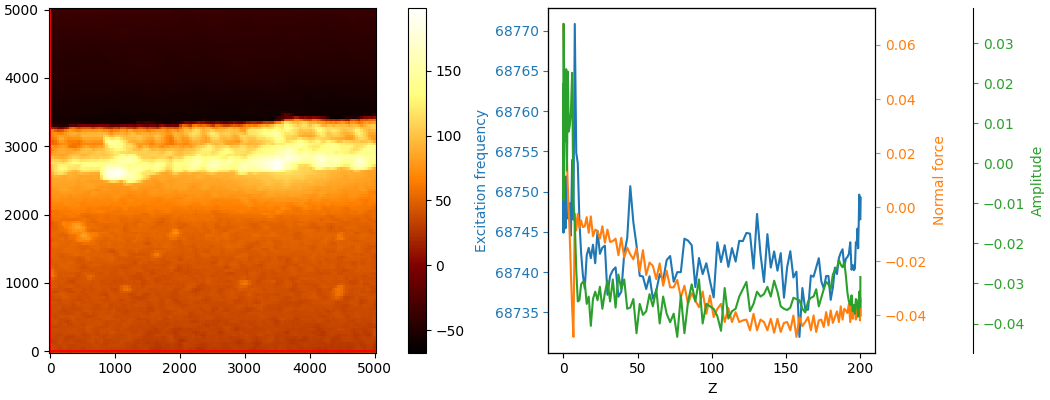

In [16]:
#close dashboard-2 figure if already open
for fignum_i in plt.get_fignums():
    figlab_i = plt.figure(fignum_i).get_label()
    if figlab_i == 'dash2':
        plt.close(figlab_i) 
    
fig2, ax2 = plt.subplots(1,2, figsize=(10.5,4), num='dash2',layout='constrained')
ax2_spec = [ax2[1], ax2[1].twinx(), ax2[1].twinx()]
ax2_spec[-1].spines['right'].set_position(('axes', 1.3))
fig2.canvas.header_visible = False
fig2.canvas.toolbar_position = 'bottom'

#topography
xx, yy, zz = get_imgdata(data_dict['Topography'][f'Image {img_dir} with Forward Ramps'])
vmin, vmax = zz.min(), zz.max()
pmesh_top2 = ax2[0].pcolormesh(xx,yy,zz, cmap='afmhot',vmin=chan_mins['Topography'],
                                vmax=chan_maxs['Topography'])
cb_top2 = plt.colorbar(pmesh_top2, ax=ax2[0])

#spectroscopy
spec_dir = 'approach'
color_list = sns.color_palette()
spec_line2 = {}
for i, channel in enumerate(chan_list):
    spectro_data = wsxm_getspectro(data_dict, channel=channel, img_dir=img_dir)
    df_spectro, data_param = wsxm_calcspectroparam(spectro_data, channel)
    df_spectro['channel'] = channel
    df_spectro_filt = df_spectro[df_spectro['segment'].isin([spec_dir])].reset_index(drop=True) #filter to selected direction
    spec_line2[channel] = sns.lineplot(data=df_spectro_filt, x="x", y="y", ax=ax2_spec[i], color=color_list[i])
    ax2_spec[i].set_ylabel(channel)
    ax2_spec[i].yaxis.label.set_color(color_list[i])
    ax2_spec[i].tick_params(axis='y', colors=color_list[i]) 

ax2_spec[0].set_xlabel('Z')

#position lines on topo
line_h2 = ax2[0].axhline(ymin, xmin, xmax, linestyle='solid', color='r')
line_v2 = ax2[0].axvline(xmin, ymin, ymax, linestyle='solid', color='r')
# plt.tight_layout()

#widgets
slide_x2 = widgets.IntSlider(value=xmin, min=xmin, max=xmax, step=(xmax-xmin)/x_num,
                            description='x')
slide_y2 = widgets.IntSlider(value=ymin, min=ymin, max=ymax, step=(ymax-ymin)/y_num,
                            description='y')
slide_zrange2 = widgets.IntSlider(value=zmax, min=zmin, max=zmax, step=(zmax-zmin)/z_num,
                            description='z limit')
slide_cb2 = widgets.FloatRangeSlider(value=[vmin, vmax], min=vmin, max=vmax,
                                     step=(vmax-vmin)/100, description='color',readout=True)
specdir_button2 = widgets.ToggleButtons(options=['approach', 'retract'], #CHANGE TO MULTIPLE SELECT!
                                    # description='Channel:',
                                     disabled=False)
imgdir_button2 = widgets.ToggleButtons(options=['Forward', 'Backward'],
                                    # description='Channel:',
                                     disabled=False)
param_dropdown2 = widgets.Dropdown(options=param_list,
                                  value='Topography',disabled=False)
dash2_output = widgets.Output()
dash2_box1 = widgets.VBox([slide_x2, slide_y2, slide_zrange2, slide_cb2])
dash2_box2 = widgets.VBox([param_dropdown2, imgdir_button2])
dash2_box3 = widgets.VBox([specdir_button2])

#update functions

@dash2_output.capture()
def dash2_update_x(change):
    img_dir = imgdir_button2.value
    spec_dir = specdir_button2.value
    x_pt = change.new
    y_pt = slide_y2.value

    # df_spectro_list, data_param_dict = [], {}
    for i, channel in enumerate(chan_list):
        spectro_data = wsxm_getspectro(data_dict, channel=channel, img_dir=img_dir, x=x_pt, y= y_pt)
        df_spectro, data_param = wsxm_calcspectroparam(spectro_data, channel)
        df_spectro['channel'] = channel
        df_spectro_filt = df_spectro[df_spectro['segment'].isin([spec_dir])].reset_index(drop=True) #filter to selected direction
        spec_line2[channel].get_lines()[0].set_data(df_spectro_filt['x'],df_spectro_filt['y'])
        ax2_spec[i].set_ylim(df_spectro_filt['y'].min(), df_spectro_filt['y'].max())
    line_v2.set_xdata([x_pt]) #vertical line on topo
    fig2.canvas.draw()

@dash2_output.capture()
def dash2_update_y(change):
    img_dir = imgdir_button2.value
    spec_dir = specdir_button2.value
    x_pt = slide_x2.value
    y_pt = change.new
    
    # df_spectro_list, data_param_dict = [], {}
    for i, channel in enumerate(chan_list):
        spectro_data = wsxm_getspectro(data_dict, channel=channel, img_dir=img_dir, x=x_pt, y= y_pt)
        df_spectro, data_param = wsxm_calcspectroparam(spectro_data, channel)
        df_spectro['channel'] = channel
        df_spectro_filt = df_spectro[df_spectro['segment'].isin([spec_dir])].reset_index(drop=True) #filter to selected direction
        spec_line2[channel].get_lines()[0].set_data(df_spectro_filt['x'],df_spectro_filt['y'])
        ax2_spec[i].set_ylim(df_spectro_filt['y'].min(), df_spectro_filt['y'].max())
    line_h2.set_ydata([y_pt]) #horizontal line on topo
    fig2.canvas.draw()

@dash2_output.capture()
def dash2_update_zrange(change):
    z_new = change.new
    for i, channel in enumerate(chan_list):
        ax2_spec[i].set_xlim(zmin, z_new)

@dash2_output.capture()
def dash2_update_param(change):
    img_dir = imgdir_button2.value
    if change.new == 'Topography':
        xx, yy, zz = get_imgdata(data_dict[change.new][f'Image {img_dir} with Forward Ramps'])
    else:
        xx, yy, zz = get_imgdata(param_data_dict[change.new][imgdir_button2.value])
    pmesh_top2.set_array(zz)
    vmin, vmax = zz.min(), zz.max()
    pmesh_top2.set_clim(vmin, vmax)
    cb_top2.mappable.set_clim(vmin, vmax)
    fig2.canvas.draw()

    #reinitialize colorbar to new values of channel(works somehow)
    slide_cb2.unobserve(dash2_update_colorbar, 'value')
    slide_cb2.min, slide_cb2.max = -1e100, 1e100 #to avoid error of min, max classh from previous value
    slide_cb2.step = (vmax-vmin)/100
    slide_cb2.value = (vmin, vmax)
    # slide_cb.min, slide_cb.max = chan_mins[channel], chan_maxs[channel]
    slide_cb2.observe(dash2_update_colorbar, 'value')

@dash2_output.capture()
def dash2_update_imgdir(change):
    img_dir = change.new
    x_pt = slide_x2.value
    y_pt = slide_y2.value
    spec_dir = specdir_button2.value
    vmin, vmax = slide_cb2.value
    
    if param_dropdown2.value == 'Topography':
        xx, yy, zz = get_imgdata(data_dict[param_dropdown2.value][f'Image {img_dir} with Forward Ramps'])
    else:
        xx, yy, zz = get_imgdata(param_data_dict[param_dropdown2.value][img_dir])
    pmesh_top2.set_array(zz)
    pmesh_top2.set_clim(vmin,vmax)

    # df_spectro_list, data_param_dict = [], {}
    for i, channel in enumerate(chan_list):
        spectro_data = wsxm_getspectro(data_dict, channel=channel, img_dir=img_dir, x=x_pt, y= y_pt)
        df_spectro, data_param = wsxm_calcspectroparam(spectro_data, channel)
        df_spectro['channel'] = channel
        df_spectro_filt = df_spectro[df_spectro['segment'].isin([spec_dir])].reset_index(drop=True) #filter to selected direction
        spec_line2[channel].get_lines()[0].set_data(df_spectro_filt['x'],df_spectro_filt['y'])
        ax2_spec[i].set_ylim(df_spectro_filt['y'].min(), df_spectro_filt['y'].max())
    fig2.canvas.draw()

@dash2_output.capture()
def dash2_update_specdir(change):
    img_dir = imgdir_button2.value
    x_pt = slide_x2.value
    y_pt = slide_y2.value
    spec_dir = change.new

    # df_spectro_list, data_param_dict = [], {}
    for i, channel in enumerate(chan_list):
        spectro_data = wsxm_getspectro(data_dict, channel=channel, img_dir=img_dir, x=x_pt, y= y_pt)
        df_spectro, data_param = wsxm_calcspectroparam(spectro_data, channel)
        df_spectro['channel'] = channel
        df_spectro_filt = df_spectro[df_spectro['segment'].isin([spec_dir])].reset_index(drop=True) #filter to selected direction
        spec_line2[channel].get_lines()[0].set_data(df_spectro_filt['x'],df_spectro_filt['y'])
        ax2_spec[i].set_ylim(df_spectro_filt['y'].min(), df_spectro_filt['y'].max())
    fig2.canvas.draw()

@dash2_output.capture()
def dash2_update_colorbar(change):
    vmin, vmax = change.new
    img_dir = imgdir_button2.value
    if param_dropdown2.value == 'Topography':
        xx, yy, zz = get_imgdata(data_dict[param_dropdown2.value][f'Image {img_dir} with Forward Ramps'])
    else:
        xx, yy, zz = get_imgdata(param_data_dict[param_dropdown2.value][img_dir])
    
    if slide_cb2.min != zz.min() or  slide_cb2.max != zz.max():
        #slider reset to channel values
        vmin, vmax = zz.min(), zz.max()
        slide_cb2.unobserve(dash2_update_colorbar, 'value')
        slide_cb2.min, slide_cb2.max = -1e100, 1e100 #to avoid error of min, max classh from previous value
        slide_cb2.min, slide_cb2.max = vmin, vmax
        slide_cb2.step = (vmin - vmax)/100
        slide_cb2.value = (vmin, vmax)
        slide_cb2.observe(dash2_update_colorbar, 'value')
    else:
        pmesh_top2.set_clim(vmin, vmax)
        cb_top2.mappable.set_clim(vmin, vmax)
        fig2.canvas.draw()

#update x,y cordinates by clicking inside the plot
@dash2_output.capture()
def dash2_onclick(event):
    if event.inaxes == ax2[0]:
        slide_x2.value = event.xdata
        slide_y2.value = event.ydata

# @dash2_output.capture()
# def response(change):
#     print(change)
     
slide_x2.observe(dash2_update_x, 'value')
slide_y2.observe(dash2_update_y, 'value')
slide_zrange2.observe(dash2_update_zrange, 'value')
slide_cb2.observe(dash2_update_colorbar,'value')
param_dropdown2.observe(dash2_update_param, 'value')
imgdir_button2.observe(dash2_update_imgdir, 'value')
specdir_button2.observe(dash2_update_specdir, 'value')
dash2_cid = fig2.canvas.mpl_connect('button_press_event', dash2_onclick)

display(dash2_box1)
display(dash2_box2)
display(dash2_box3)
display(dash2_output)

### Calculated image maps and statistics

In [4]:
#close dashboard-3 figure if already open
for fignum_i in plt.get_fignums():
    figlab_i = plt.figure(fignum_i).get_label()
    if figlab_i in ['dash3a', 'dash3b']:
        plt.close(figlab_i)
imgdir = 'Forward'
# bin_num3 = 100 #number of bins for histogram

dash3_figa = widgets.Output()
fig3_dict = {'a':{'fig':'', 'ax':''}, 'b': {'fig':'', 'ax':''}}
fig3_subplotrows = (len(param_list)//2) + (len(param_list)%2)
with plt.ioff():
    fig3_dict['a']['fig'], fig3_dict['a']['ax'] = plt.subplots(fig3_subplotrows, 2, figsize=(10, 4*fig3_subplotrows), 
                                                               sharey=True, num='dash3a', layout='constrained')

if len(param_list) == 1: #put it in list to avoid indexing error later
        fig3_dict['a']['ax'] = [fig3_dict['a']['ax']]
else:
    fig3_dict['a']['ax'] = fig3_dict['a']['ax'].flatten()
    if len(param_list)%2 == 1: #clear final empty plot if it exists
        fig3_dict['a']['ax'][-1].set_axis_off()

pmesh_top3, cb_top3, slide_range3 = {}, {}, {}
param_data_long = {}
vmin_set, vmax_set = {}, {}
# fig3a_cb_loc = 'bottom' if len(param_list)>3 else 'right' #adjust colorbar location for aesthetics
for i, param_i in enumerate(param_list):
    if param_i == 'Topography':
        xx, yy, zz = get_imgdata(data_dict[param_i][f'Image {img_dir} with Forward Ramps'])
    else:
        xx, yy, zz = get_imgdata(param_data_dict[param_i][imgdir])
    vmin, vmax = zz.min(), zz.max()
    param_data_long[param_i] = zz.flatten()
    #set data range between 1 and 99 percentile
    vmin_set[param_i] = np.percentile(param_data_long[param_i], 1, method='midpoint')
    vmax_set[param_i] = np.percentile(param_data_long[param_i], 99, method='midpoint')
    pmesh_top3[param_i] = fig3_dict['a']['ax'][i].pcolormesh(xx,yy,zz, cmap='afmhot',vmin=vmin_set[param_i], vmax=vmax_set[param_i])
    with plt.ioff():
        fig3_dict['a']['ax'][i].set_box_aspect(1) 
        cb_top3[param_i] = plt.colorbar(pmesh_top3[param_i], ax=fig3_dict['a']['ax'][i])#, location=fig3a_cb_loc)
        fig3_dict['a']['ax'][i].set_title(param_i)
    #range slider
    slide_range3[param_i] = widgets.FloatRangeSlider(value=(vmin_set[param_i],vmax_set[param_i]),
                                                     min=vmin, max=vmax,step=(vmax-vmin)/1000,
                                                     description=param_i,readout=True)

# fig3_dict['a']['fig'].tight_layout()
with dash3_figa:
    fig3_dict['a']['fig'].canvas.header_visible = False
    fig3_dict['a']['fig'].canvas.toolbar_position = 'bottom'
    display(fig3_dict['a']['fig'].canvas)

# fig3_1, ax3_1 = plt.subplots(1,1)
param_data_df = pd.DataFrame(param_data_long)
param_data_df_filt = param_data_df.copy(deep=True)
for param_i in param_list:
    param_data_df_filt[param_i] = param_data_df_filt[param_i].where((param_data_df[param_i]>=vmin_set[param_i]) & \
                                                                    (param_data_df[param_i]<=vmax_set[param_i]), None)

dash3_figb = widgets.Output()
with plt.ioff():
    dash3_g = sns.pairplot(param_data_df_filt, diag_kind = 'kde', height=2,
                           plot_kws=dict(edgecolors='none', s=5))#, diag_kws=dict(bins=bin_num3))
with dash3_figb:
    fig3_dict['b']['fig'] = dash3_g.figure
    plt.figure(fig3_dict['b']['fig'].number).set_label('dash3b')
    # fig3_dict['b']['fig'].canvas.manager.set_window_title('dash3b')
    fig3_dict['b']['fig'].canvas.header_visible = False
    fig3_dict['b']['fig'].canvas.toolbar_position = 'bottom'
    display(fig3_dict['b']['fig'].canvas)

#widgets
imgdir_button3 = widgets.ToggleButtons(options=['Forward', 'Backward'],
                                    # description='Channel:',
                                       disabled=False)
dash3_chan_select = widgets.SelectMultiple(options=param_list, value=param_list,
                                          description='channels', diabled=False)
dash3_output = widgets.Output()
dash3_box1 = widgets.VBox([imgdir_button3, dash3_chan_select])
dash3_box2 = widgets.VBox(list(slide_range3.values()))
dash3_box3 = widgets.HBox([dash3_box1, dash3_box2])

dash3_initcount = 0

@dash3_output.capture()
def dash3_update_plots(change):
    # print('here', change)
    global dash3_initcount #to avoid running during first execution of program for each slider (its a bug)
    if dash3_initcount < len(slide_range3):
        dash3_initcount += 1
    else:
        img_dir = imgdir_button3.value
        paramlist_select = list(dash3_chan_select.value)
        if change.owner.description != '': #only when sliders are changed
            vmin, vmax = change.new
            param_i = change.owner.description
        
        param_data_df_filt = param_data_df.copy(deep=True)
        
        for i, param_i in enumerate(paramlist_select):
            if param_i == 'Topography':
                xx, yy, zz = get_imgdata(data_dict[param_i][f'Image {img_dir} with Forward Ramps'])
            else:
                xx, yy, zz = get_imgdata(param_data_dict[param_i][imgdir])
            vmin, vmax = slide_range3[param_i].value
            # vmin, vmax = zz.min(), zz.max()
            pmesh_top3[param_i].set_array(zz)
            pmesh_top3[param_i].set_clim(vmin, vmax)
            
            param_data_df_filt[param_i] = param_data_df_filt[param_i].where((param_data_df[param_i]>=vmin) & (param_data_df[param_i]<=vmax), None)
        fig3_dict['a']['fig'].canvas.draw()
        dash3_figb.clear_output()
        with plt.ioff():
            dash3_g = sns.pairplot(param_data_df_filt[paramlist_select],  diag_kind = 'kde', height=2, 
                                   plot_kws=dict(edgecolors='none', s=5))#, diag_kws=dict(bins=bin_num3))
        with dash3_figb:
            fig3_dict['b']['fig'] = dash3_g.figure
            plt.figure(fig3_dict['b']['fig'].number).set_label('dash3b')
            # fig3_dict['b']['fig'].canvas.manager.set_window_title('dash3b')
            # fig3_dict['b']['fig'].num='dash3b'
            fig3_dict['b']['fig'].canvas.header_visible = False
            fig3_dict['b']['fig'].canvas.toolbar_position = 'bottom'
            display(fig3_dict['b']['fig'].canvas)

@dash3_output.capture()
def dash3_update_chans(change):
    paramlist_select = list(change.new)
    img_dir = imgdir_button3.value
    fig3_subplotrows = (len(paramlist_select)//2) + (len(paramlist_select)%2)
    with plt.ioff():
        fig3_dict['a']['fig'].clear()
        fig3_dict['a']['ax'] = ''
        fig3_dict['a']['fig'], fig3_dict['a']['ax'] = plt.subplots(fig3_subplotrows, 2, figsize=(10, 4*fig3_subplotrows),  
                                                                   sharey=True, num='dash3a', layout='constrained')
    #update figure dimensions metadata (otherwise doesn't update!)
    fig3_dict['a']['fig'].set_figheight(4*fig3_subplotrows)
    fig3_dict['a']['fig'].set_figwidth(10)
    # if len(paramlist_select) == 1: #put it in list to avoid indexing error later
        # print(fig3_dict['a']['ax'])
        # fig3_dict['a']['ax'] = [fig3_dict['a']['ax']]
        # print(fig3_dict['a']['ax'])
    # else:
    fig3_dict['a']['ax'] = fig3_dict['a']['ax'].flatten()
    if len(param_list)%2 == 1:
        fig3_dict['a']['ax'][-1].set_axis_off()
    pmesh_top3.clear()
    cb_top3.clear()
    for param_i in param_list: #hide or show sliders
        if param_i in paramlist_select:
            slide_range3[param_i].layout.display = None
        else:
            slide_range3[param_i].layout.display = 'none'
    # print(fig3_dict['a']['ax'])
    param_data_df_filt = param_data_df.copy(deep=True)
    # fig3a_cb_loc = 'bottom' if len(paramlist_select)>3 else 'right' #adjust colorbar location for aesthetics
    for i, param_i in enumerate(paramlist_select):
        if param_i == 'Topography':
            xx, yy, zz = get_imgdata(data_dict[param_i][f'Image {img_dir} with Forward Ramps'])
        else:
            xx, yy, zz = get_imgdata(param_data_dict[param_i][imgdir])
        vmin, vmax = slide_range3[param_i].value
        pmesh_top3[param_i] = fig3_dict['a']['ax'][i].pcolormesh(xx,yy,zz, cmap='afmhot',vmin=vmin, 
                                                                 vmax=vmax)
        with plt.ioff():
            fig3_dict['a']['ax'][i].set_box_aspect(1) 
            cb_top3[param_i] = plt.colorbar(pmesh_top3[param_i], ax=fig3_dict['a']['ax'][i])#, location=fig3a_cb_loc)
            fig3_dict['a']['ax'][i].set_title(param_i)
        param_data_df_filt[param_i] = param_data_df_filt[param_i].where((param_data_df[param_i]>=vmin) & (param_data_df[param_i]<=vmax), 
                                                                        None)

    fig3_dict['a']['fig'].canvas.draw()

    dash3_figb.clear_output()
    with plt.ioff():
        dash3_g = sns.pairplot(param_data_df_filt[paramlist_select],  diag_kind = 'kde', height=2, 
                               plot_kws=dict(edgecolors='none', s=5))#, diag_kws=dict(bins=bin_num3))
    with dash3_figb:
        fig3_dict['b']['fig'] = dash3_g.figure
        plt.figure(fig3_dict['b']['fig'].number).set_label('dash3b')
        # fig3_dict['b']['fig'].canvas.manager.set_window_title('dash3b')
        # fig3_dict['b']['fig'].num='dash3b'
        fig3_dict['b']['fig'].canvas.header_visible = False
        fig3_dict['b']['fig'].canvas.toolbar_position = 'bottom'
        display(fig3_dict['b']['fig'].canvas)

imgdir_button3.observe(dash3_update_plots, 'value')
dash3_chan_select.observe(dash3_update_chans, 'value')
for slide_i in slide_range3.values():
    slide_i.observe(dash3_update_plots, 'value')
    
display(dash3_box3)
display(dash3_figa)
display(dash3_figb)
display(dash3_output)

Output()

Output()

Output()

In [94]:
fig3_dict['a']['fig'].set_figheight(5)
fig3_dict['a']['fig'].set_figwidth(10)

In [11]:
dash3_g.figure.num='dash3b'

## SPECTROSCOPY DATA ANALYSIS

### Data viewer

Output(layout=Layout(height='5in'))

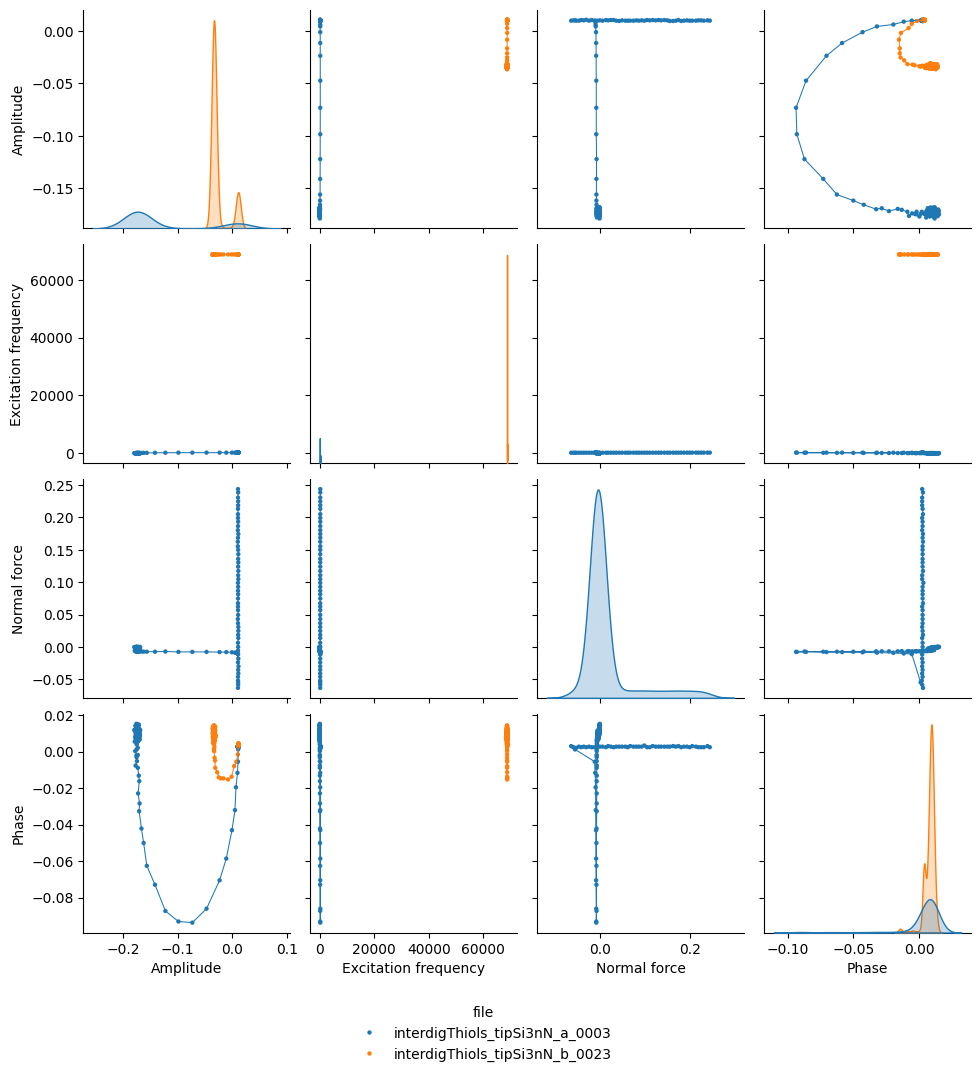

Output()

Output()

In [8]:
%matplotlib agg

# plt.close()
file_df_spectro = file_df[(file_df['type']=='1D') & (file_df['channel'] != 'Other')]
files_spectro = list(dict.fromkeys(file_df_spectro['file']))
files_spectro.sort()
chanlist_spectro = list(dict.fromkeys(file_df_spectro['channel'])) #unique channels
chanlist_spectro.sort()
zmin =  0 #FIX THIS TO VALUES FROM TABLE
zmax = max([float(s.split(' ')[0]) for s in file_df_spectro['size']])

#close dashboard-4 figure if already open
for fignum_i in plt.get_fignums():
    figlab_i = plt.figure(fignum_i).get_label()
    if figlab_i in ['dash4a', 'dash4b']:
        plt.close(figlab_i) 

#spectroscopy figure
with plt.ioff():
    fig4, ax4 = plt.subplots(1,1, figsize=(8,4), num='dash4a')#, layout='constrained')


dash4_figdict = {'a': fig4, 'b': None} #

color_list = sns.color_palette()

#widgets
dash4_output = widgets.Output()
dash4_chan_select = widgets.SelectMultiple(options=chanlist_spectro, value=[chanlist_spectro[0]],
                                          description='channels', diabled=False)
dash4_file_select = widgets.SelectMultiple(options=files_spectro, value=[files_spectro[0]],
                                          description='files')
dash4_specdir_select = widgets.SelectMultiple(options=['approach', 'retract'], 
                                              value=['approach'])
dash4_zrange_slide = widgets.FloatSlider(value=zmax, min=zmin, max=zmax, step=(zmax-zmin)/1000,
                                       description='z limit')
dash4_curvnum_slide = widgets.SelectionSlider(value=1, options=[1],
                                              description='curve no.', readout=True)
dash4_allcurv_check = widgets.Checkbox(value=False, description='All curves', indent=False)
# dash4_groupbyfile_check = widgets.Checkbox(value=False, description='Group by file', indent=False)
dash4_grid_toggle = widgets.ToggleButton(value=False, description='Show grid', button_style='', # 'success', 'info', 'warning', 'danger' or ''
                                          #tooltip='Description'#, icon='check' # (FontAwesome names without the `fa-` prefix)
                                         )
dash4_param_toggle = widgets.ToggleButton(value=False, description='Show calc', button_style='', # 'success', 'info', 'warning', 'danger' or ''
                                          #tooltip='Description'#, icon='check' # (FontAwesome names without the `fa-` prefix)
                                         )
dash4_save_button = widgets.Button(description='Save')

dash4_unit_dropdown = {}
for chan_i in chanlist_spectro:
    chan_units_i = list(CALIB_DICT[chan_i].keys())
    dash4_unit_dropdown[chan_i] = widgets.Dropdown(options=chan_units_i,value=chan_units_i[0])
    
#output widgets to display figures and tables
dash4_figaout = widgets.Output()
dash4_figaout.layout.height = '5in'
dash4_tableout = widgets.Output()

#layout
dash4_vbox1 = widgets.VBox(list(dash4_unit_dropdown.values()))
dash4_box1 = widgets.HBox([dash4_file_select, dash4_chan_select, dash4_vbox1, dash4_specdir_select])
dash4_box2 = widgets.HBox([dash4_zrange_slide, dash4_curvnum_slide, dash4_allcurv_check, 
                           dash4_param_toggle, dash4_grid_toggle, dash4_save_button])

ax4_spec = {} #dictionary of primary and secondary axis
spec_line4 = {} #dictionary of line plot objects
ax4_color = {} #dictionary of axis colours

#prepare plot with relevant y axis
# @dash4_output.capture()
def dash4_update_plotax():
    def make_patch_spines_invisible(ax):
        ax.set_frame_on(True)
        ax.patch.set_visible(False)
        for sp in ax.spines.values():
            sp.set_visible(False)

    for chan_i, ax_i in ax4_spec.items():
        ax_i.cla()
        if ax_i != ax4:
            ax_i.get_yaxis().set_visible(False)
            ax_i.remove()
        # del ax_i
    chan_selected = dash4_chan_select.value #[chanlist_spectro[0], chanlist_spectro[1]]

    ax4_spec.clear()
    # ax4_spec.append(ax4)
    ax4_spec[chan_selected[0]] = ax4
    
    for i, chan_i in enumerate(chan_selected):    
        if i > 0:
            ax4_spec[chan_i] = ax4.twinx()
            # ax4_spec.append(ax4.twinx())
        if i > 1:
            axpos_i = ['right', 'left'][i%2]
            axoffset_i = [1.2, -0.2][i%2] #offset parameters
            ax4_spec[chan_i].spines[axpos_i].set_position(('axes', axoffset_i))
            if axpos_i == 'left':
                ax4_spec[chan_i].yaxis.tick_left()
                ax4_spec[chan_i].yaxis.set_label_position(axpos_i)
                make_patch_spines_invisible(ax4_spec[chan_i])
                ax4_spec[chan_i].spines[axpos_i].set_visible(True)
                
        ax4_spec[chan_i].set_ylabel(chan_i)
        ax4_color[chan_i] = color_list[i]
        ax4_spec[chan_i].yaxis.label.set_color(ax4_color[chan_i])
        ax4_spec[chan_i].tick_params(axis='y', colors=ax4_color[chan_i])
    
    ax4_spec[chan_selected[0]].set_xlabel('Z')


@dash4_output.capture()
def dash4_update_data(change):
    dash4_update_plotax()
    chans = list(spec_line4.keys())
    for chan_i in chans:
        #remove previously plotted lines (CHECK THIS! maybe other artists need to be added)
        for ln_i in spec_line4[chan_i].get_lines()+spec_line4[chan_i].collections:
            ln_i.remove()
        del spec_line4[chan_i]
    spec_dir = dash4_specdir_select.value
    files_spectro_filt = dash4_file_select.value
    chan_selected = dash4_chan_select.value
    curve_numall = []
    spectro_data_long = {}
    spectrodf_filt_list = []
    spectroparam_dict = {} 
    
    paramval_dict = {'file':[], 'channel':[], 'curve number': [], 'parameter':[], 'value':[]}
    zmin, zmax = np.inf, -np.inf
    for i, file_i in enumerate(files_spectro_filt):
        filepath_i = folderpath + '/' + file_df_spectro.loc[(file_df_spectro.file==file_i)].iloc[0].loc['name']
        spectro_data_i = wsxm_readspectra(filepath_i, all_files=True, mute=True)
        spectro_data_long[file_i] = {'file': []}
        spectroparam_dict[file_i] = {}
        for chan_i in spectro_data_i.keys():#enumerate(chan_selected):
            # if chan_i not in spectro_data_i.keys():
            #     continue
            curve_numlist = list(spectro_data_i[chan_i]['curves'].keys()) #number of curves
            curve_numall += curve_numlist
            dash4_curvnum_slide.unobserve(dash4_update_data, 'value')
            dash4_curvnum_slide.options = list(dict.fromkeys(curve_numall))
            dash4_curvnum_slide.observe(dash4_update_data, 'value')
            if dash4_curvnum_slide.value in curve_numlist:
                curv_ind = dash4_curvnum_slide.value
            else:
                dash4_curvnum_slide.unobserve(dash4_update_data, 'value')
                dash4_curvnum_slide.value, curv_ind = curve_numlist[0], curve_numlist[0]
                dash4_curvnum_slide.observe(dash4_update_data, 'value')
            
            if dash4_allcurv_check.value == False: #show all curves in the selected files if True
                curve_numlist = [curv_ind]
            spectro_data_long[file_i][chan_i] = []
            spectro_data_long[file_i]['file'] = []
            spectro_data_long[file_i]['curve number'] = []
            spectroparam_dict[file_i][chan_i] = {}
            spectro_data_long[file_i]['segment'] = []
            for curv_ind in curve_numlist:
                spectro_data_chani = spectro_data_i[chan_i]['curves'][curv_ind]['data']
                unit_i = dash4_unit_dropdown[chan_i].value
                spectrodf_i, spectroparam_i = wsxm_calcspectroparam(spectro_data_chani, chan_i, unit=unit_i) #CHECK CALIBRATION EVERYWHERE! TODO!
                # spectroparam_dict[chan_i] = spectroparam_i
                spectroparam_dict[file_i][chan_i][curv_ind] = spectroparam_i
                # print(spectroparam_i)
                spectrodf_filt_i = spectrodf_i[spectrodf_i['segment'].isin(spec_dir)]#.reset_index(drop=True) #filter to selected direction
                #Shift Normal force to zero. MAKE THIS MORE STANDARD
                # print(spectroparam_i.keys())
                zero_shift_i = spectroparam_i['Adhesion']['zero'] if chan_i == 'Normal force' else 0
                spectrodf_filt_i.loc[:,'y'] = spectrodf_filt_i.loc[:,'y']-zero_shift_i
                spectrodf_filt_i.insert(0,'channel',chan_i)
                spectrodf_filt_i.insert(0,'file',file_i)
                spectrodf_filt_i.insert(0,'curve number',curv_ind)
                
                spectrodf_filt_list.append(spectrodf_filt_i)

                #collect data for pair plot and statistics for all channels
                spectro_data_long[file_i]['file'] += [file_i]*len(spectrodf_filt_i['y'])
                spectro_data_long[file_i]['curve number'] += [curv_ind]*len(spectrodf_filt_i['y'])
                spectro_data_long[file_i][chan_i] += spectrodf_filt_i['y'].to_list()
                spectro_data_long[file_i]['segment'] += spectrodf_filt_i['segment'].to_list()
                
                # print(curv_ind)

                #collected calculated parameters for all channels
                for param_i, param_dict_i in spectroparam_i.items():
                    paramval_dict['file'].append(file_i)
                    paramval_dict['channel'].append(chan_i)
                    paramval_dict['curve number'].append(curv_ind)
                    paramval_dict['parameter'].append(param_i)
                    paramval_dict['value'].append(param_dict_i['value'])
                
    
    spectrodf_filt_full = pd.concat(spectrodf_filt_list)
    # spectroparam_full = pd.concat(spectroparam_list)
    #plot spectroscopy only for selected channels
    for chan_i in chan_selected:
        size_list = [1,2,3,4,5,6]
        # line4_size = size_list[i] if dash4_groupbyfile_check.value == True else 2
        spectrodf_filt_i = spectrodf_filt_full[spectrodf_filt_full['channel']==chan_i]
        # print('jhh', spectrodf_filt_i)
        # spectroparam_i = spectroparam_dict[chan_i]
        # zero_shift_i = spectroparam_i['Adhesion']['zero'] if chan_i == 'Normal force' else 0
        # label_i = file_i if dash4_groupbyfile_check.value == True and len(dash4_specdir_select.value) == 1 else None
        # legend_i = False if dash4_groupbyfile_check.value == False and len(dash4_specdir_select.value) == 1 else True
        with plt.ioff():
                spec_line4[chan_i] = sns.lineplot(data=spectrodf_filt_i, x="x", y="y", style="segment", size="file",
                                                  units="curve number", ax=ax4_spec[chan_i], 
                                                  color=ax4_color[chan_i], sort=False, estimator=None)
                sns.move_legend(spec_line4[chan_i], loc="upper center", bbox_to_anchor=(0.5, -0.15), ncol=2)
            #     plt.legend(bbox_to_anchor=(1.02,1), loc='upper left', borderaxespad=0)
            # if dash4_groupbyfile_check.value == True and len(dash4_specdir_select.value) == 1:
            #     spec_line4[chan_i] = sns.lineplot(data=spectrodf_filt_i, x="x", y="y", #style="segment", 
            #                                       linewidth=line4_size, ax=ax4_spec[chan_i], 
            #                                       color=ax4_color[chan_i], label=file_i)
            # else:
            #     spec_line4[chan_i] = sns.lineplot(data=spectrodf_filt_i, x="x", y="y", style="segment", 
            #                                       linewidth=line4_size, ax=ax4_spec[chan_i], 
            #                                       color=ax4_color[chan_i])
            #     handles, labels = spec_line4[chan_i].get_legend_handles_labels()
            #     leg = spec_line4[chan_i].legend(handles=handles, labels=labels)
        
        # spec_line4[chan_i].relim()    
        zmin = spectrodf_filt_i['x'].min() if spectrodf_filt_i['x'].min() < zmin else zmin
        zmax = spectrodf_filt_i['x'].max() if spectrodf_filt_i['x'].max() > zmax else zmax 
    # print(spectroparam_dict)
    #plot calculated parameters
    for file_i, param_file_i in spectroparam_dict.items():
        for chan_i, param_chan_i in param_file_i.items():
            if chan_i in chan_selected:
                for curv_ind, spectroparam_i in param_chan_i.items():
                    zero_shift_i = spectroparam_i['Adhesion']['zero'] if chan_i == 'Normal force' else 0
                    for param_i, param_dict_i in spectroparam_i.items():
                        # print(param_dict_i, param_i, chan_i)
                        #plot parameter calculation lines, fits. Only plot if parameter calculated for selected segment
                        if param_dict_i['segment'] in dash4_specdir_select.value: #CHECK THIS!
                            if dash4_param_toggle.value == True:
                                if FUNC_DICT[chan_i][param_i]['plot type'] == 'line': #CHECK THIS!
                                    with plt.ioff():
                                        param_line_i = ax4_spec[chan_i].plot(param_dict_i['x'], param_dict_i['y']-zero_shift_i,
                                                                        'k', linestyle='dashed',linewidth=2)
                                else:
                                    for paramtype_i, ptype_i in FUNC_DICT[chan_i][param_i]['plot type'].items():
                                        if ptype_i == 'hline':
                                            with plt.ioff():
                                                param_line_i = ax4_spec[chan_i].hlines(param_dict_i[paramtype_i]-zero_shift_i, #CHECK THIS
                                                                                  spectrodf_i['x'].min(), spectrodf_i['x'].max(), 
                                                                                  linestyles='dashed', colors='k')
                                        elif ptype_i == 'vline': #ADD OTHER PLOT TYPES HERE TODO!
                                            pass
    
    if change not in ['init', 'save'] and change.owner.description == 'files':
        dash4_zrange_slide.value = zmax

    #
    # if dash4_groupbyfile_check.value == True and len(dash4_specdir_select.value) == 1:
    # fig4_leg = fig4.legend(loc='outside right upper')
    # handles_list, labels_list = [], []
    # for ax4_i in ax4_spec.values():
    #     handles, labels = ax4_i.get_legend_handles_labels()
    #     handles_list += handles
    #     labels_list += labels
            
    # by_label = dict(zip(labels_list, handles_list))
    # # print(by_label)
    # ax4_i.legends = []
    # ax4_i.legend(by_label.values(), by_label.keys())#, loc='outside right upper', draggable=True)
            
    # else:
    #     fig4.legends = []
    # fig4.tight_layout()
    dash4_figaout.clear_output(wait=True)
    with dash4_figaout: 
        display(fig4)
    
    # spectro_data_longdf = pd.concat([pd.DataFrame(d) for d in spectro_data_long.values()])
    spectro_data_longdf = pd.concat([pd.DataFrame.from_dict({k: pd.Series(v) for k, v in d.items()}) for d in spectro_data_long.values()], 
                                    ignore_index=True) #CHECK THIS, MAYBE NOT CORRECT WITH MULTIPLE FILES

    # if dash4_groupbyfile_check.value == True:
    # hue_col = 'file' #if len(spectro_data_longdf['file'].unique())>1 else None
    paramval_groupcols = ['channel', 'parameter', 'file']
    
    # else:
    #     paramval_groupcols = ['channel', 'parameter']
    #     hue_col = None
    # display(spectro_data_longdf)
    #don't update statistics if only channel or specro specific widget values changed
    if change in ['init', 'save'] or change.owner.description not in ['channels', 'Show calc', 'Show grid']:
        plt.close('dash4b')
        with plt.ioff():
            # print(spectro_data_longdf.columns)
            long_cols = list(spectro_data_longdf.columns)
            long_cols.remove('file')
            long_cols.remove('curve number')
            long_cols.remove('segment')
            long_cols.sort()
            dash4_g = sns.pairplot(spectro_data_longdf, vars = long_cols, hue='file', 
                                   diag_kind = 'kde', plot_kws=dict(edgecolors='none', s=10))            
            dash4_g.map_offdiag(sns.lineplot, units=spectro_data_longdf['curve number'], 
                                size=spectro_data_longdf['segment'], 
                                sort=False, dashes=False, estimator=None)#, color=".2")
        sns.move_legend(dash4_g, loc="upper right", bbox_to_anchor=(0.5, 0))#, ncol=2)
        dash4_figb = dash4_g.figure
        dash4_figdict['b'] = dash4_figb
        plt.figure(dash4_figb.number).set_label('dash4b')
        dash4_g.figure.canvas.draw()
        dash4_figb_disp.update(dash4_g.figure)

    
        #statistics of spectroscopy calculated parameters
        paramval_df = pd.DataFrame(paramval_dict)
        paramval_grouped = paramval_df.groupby(paramval_groupcols)
        paramval_summary = paramval_grouped['value'].agg(['mean', 'std']).reset_index()
        
        dash4_tableout.clear_output()
        with dash4_tableout:
            itables.show(paramval_summary)

    if change == 'save':
        timestamp = datetime.datetime.now().strftime('%y%m%d-%H%M%S')
        dash4_outfilepath = f'{outputpath}/spectroscopy_results_{timestamp}' #COMPLETE THIS! ALSO SAVE PLOTS!
        with pd.ExcelWriter(f'{dash4_outfilepath}.xlsx', mode="w", engine="openpyxl") as writer:
            paramval_df.to_excel(writer, sheet_name="Data")
        with pd.ExcelWriter(f'{dash4_outfilepath}.xlsx', mode="a", engine="openpyxl") as writer:
            paramval_summary.to_excel(writer, sheet_name="Statistics")
        dash4_figdict['a'].savefig(f'{dash4_outfilepath}_spectroplot.png', bbox_inches = 'tight', transparent = False)
        dash4_figdict['b'].savefig(f'{dash4_outfilepath}_correlationplot.png', bbox_inches = 'tight', transparent = False)


@dash4_output.capture()
def dash4_update_zrange(change):
    z_new = change.new
    for axi in ax4_spec.values():
        axi.set_xlim(zmin, z_new)
    dash4_figaout.clear_output(wait=True)
    with dash4_figaout:
        display(fig4)

@dash4_output.capture()
def dash4_update_grid(change):
    ax4_spec[list(ax4_spec.keys())[0]].grid()
    dash4_figaout.clear_output(wait=True)
    with dash4_figaout:
        display(fig4)

@dash4_output.capture()
def dash4_save_click(change):
    dash4_update_data('save')
    
dash4_chan_select.observe(dash4_update_data, 'value')
dash4_file_select.observe(dash4_update_data, 'value')
dash4_specdir_select.observe(dash4_update_data, 'value')
dash4_zrange_slide.observe(dash4_update_zrange, 'value')
dash4_curvnum_slide.observe(dash4_update_data, 'value')
dash4_allcurv_check.observe(dash4_update_data, 'value')
# dash4_groupbyfile_check.observe(dash4_update_data, 'value')
dash4_param_toggle.observe(dash4_update_data, 'value')
dash4_grid_toggle.observe(dash4_update_grid, 'value')
for dash4_dropi in dash4_unit_dropdown.values():
    dash4_dropi.observe(dash4_update_data, 'value')
dash4_save_button.on_click(dash4_save_click)



display(dash4_box1)
display(dash4_box2)
display(dash4_figaout)
dash4_figb_disp = display("figb", display_id='dash4_figb') #display handle for pair plot to avoid memory leak
dash4_update_data('init') 
dash4_figb_disp.update(dash4_figdict['b']) #update pairplot
display(dash4_tableout)
display(dash4_output)

In [7]:
t = ['b', 'a', 'c']
t.sort()
print(t)

['a', 'b', 'c']


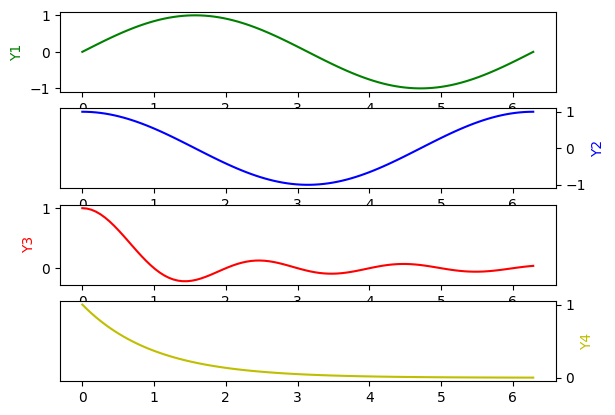

In [2]:
# import matplotlib.pyplot as plt
# import matplotlib.gridspec as gridspec
# import numpy as np

# # Create some data
# x = np.linspace(0, 2 * np.pi, 100)
# y1 = np.sin(x)
# y2 = np.cos(x)
# y3 = np.sinc(x)
# y4 = np.exp(-x)

# # Create a gridspec
# gs = gridspec.GridSpec(4, 1)

# # Create the first y-axis on the left side
# ax1 = plt.subplot(gs[0])
# ax1.plot(x, y1, 'g-')
# ax1.set_ylabel('Y1', color='g')

# # Create the second y-axis on the left side
# ax2 = plt.subplot(gs[1], sharex=ax1)
# ax2.plot(x, y2, 'b-')
# ax2.yaxis.tick_right()
# ax2.yaxis.set_label_position("right")
# ax2.set_ylabel('Y2', color='b')

# # Create the third y-axis on the right side
# ax3 = plt.subplot(gs[2], sharex=ax1)
# ax3.plot(x, y3, 'r-')
# ax3.set_ylabel('Y3', color='r')

# # Create the fourth y-axis on the right side
# ax4 = plt.subplot(gs[3], sharex=ax1)
# ax4.plot(x, y4, 'y-')
# ax4.yaxis.tick_right()
# ax4.yaxis.set_label_position("right")
# ax4.set_ylabel('Y4', color='y')

# plt.show()


In [56]:
#dashboard 4: Spectroscopy data viewer


#close dashboard-4 figure if already open
for fignum_i in plt.get_fignums():
    figlab_i = plt.figure(fignum_i).get_label()
    if figlab_i == 'dash4':
        plt.close(figlab_i) 
    
fig4, ax4 = plt.subplots(1,1, figsize=(10.5,4), num='dash4',layout='constrained')
ax2_spec = [ax2[1], ax2[1].twinx(), ax2[1].twinx()]
ax2_spec[-1].spines['right'].set_position(('axes', 1.3))
fig2.canvas.header_visible = False
fig2.canvas.toolbar_position = 'bottom'

#topography
xx, yy, zz = get_imgdata(data_dict['Topography'][f'Image {img_dir} with Forward Ramps'])
vmin, vmax = zz.min(), zz.max()
pmesh_top2 = ax2[0].pcolormesh(xx,yy,zz, cmap='afmhot',vmin=chan_mins['Topography'],
                                vmax=chan_maxs['Topography'])
cb_top2 = plt.colorbar(pmesh_top2, ax=ax2[0])

#spectroscopy
spec_dir = 'approach'
color_list = sns.color_palette()
spec_line2 = {}
for i, channel in enumerate(chan_list):
    spectro_data = wsxm_getspectro(data_dict, channel=channel, img_dir=img_dir)
    df_spectro, data_param = wsxm_calcspectroparam(spectro_data, channel)
    df_spectro['channel'] = channel
    df_spectro_filt = df_spectro[df_spectro['segment'].isin([spec_dir])].reset_index(drop=True) #filter to selected direction
    spec_line2[channel] = sns.lineplot(data=df_spectro_filt, x="x", y="y", ax=ax2_spec[i], color=color_list[i])
    ax2_spec[i].set_ylabel(channel)
    ax2_spec[i].yaxis.label.set_color(color_list[i])
    ax2_spec[i].tick_params(axis='y', colors=color_list[i]) 

ax2_spec[0].set_xlabel('Z')

#position lines on topo
line_h2 = ax2[0].axhline(ymin, xmin, xmax, linestyle='solid', color='r')
line_v2 = ax2[0].axvline(xmin, ymin, ymax, linestyle='solid', color='r')
# plt.tight_layout()

#widgets
slide_x2 = widgets.IntSlider(value=xmin, min=xmin, max=xmax, step=(xmax-xmin)/x_num,
                            description='x')
slide_y2 = widgets.IntSlider(value=ymin, min=ymin, max=ymax, step=(ymax-ymin)/y_num,
                            description='y')
slide_zrange2 = widgets.IntSlider(value=zmax, min=zmin, max=zmax, step=(zmax-zmin)/z_num,
                            description='z limit')
slide_cb2 = widgets.FloatRangeSlider(value=[vmin, vmax], min=vmin, max=vmax,
                                     step=(vmax-vmin)/100, description='color',readout=True)
specdir_button2 = widgets.ToggleButtons(options=['approach', 'retract'], #CHANGE TO MULTIPLE SELECT!
                                    # description='Channel:',
                                     disabled=False)
imgdir_button2 = widgets.ToggleButtons(options=['Forward', 'Backward'],
                                    # description='Channel:',
                                     disabled=False)
param_dropdown2 = widgets.Dropdown(options=param_list,
                                  value='Topography',disabled=False)
dash2_output = widgets.Output()
dash2_box1 = widgets.VBox([slide_x2, slide_y2, slide_zrange2, slide_cb2])
dash2_box2 = widgets.VBox([param_dropdown2, imgdir_button2])
dash2_box3 = widgets.VBox([specdir_button2])

#update functions

@dash2_output.capture()
def dash2_update_x(change):
    img_dir = imgdir_button2.value
    spec_dir = specdir_button2.value
    x_pt = change.new
    y_pt = slide_y2.value

    # df_spectro_list, data_param_dict = [], {}
    for i, channel in enumerate(chan_list):
        spectro_data = wsxm_getspectro(data_dict, channel=channel, img_dir=img_dir, x=x_pt, y= y_pt)
        df_spectro, data_param = wsxm_calcspectroparam(spectro_data, channel)
        df_spectro['channel'] = channel
        df_spectro_filt = df_spectro[df_spectro['segment'].isin([spec_dir])].reset_index(drop=True) #filter to selected direction
        spec_line2[channel].get_lines()[0].set_data(df_spectro_filt['x'],df_spectro_filt['y'])
        ax2_spec[i].set_ylim(df_spectro_filt['y'].min(), df_spectro_filt['y'].max())
    line_v2.set_xdata([x_pt]) #vertical line on topo
    fig2.canvas.draw()

@dash2_output.capture()
def dash2_update_y(change):
    img_dir = imgdir_button2.value
    spec_dir = specdir_button2.value
    x_pt = slide_x2.value
    y_pt = change.new
    
    # df_spectro_list, data_param_dict = [], {}
    for i, channel in enumerate(chan_list):
        spectro_data = wsxm_getspectro(data_dict, channel=channel, img_dir=img_dir, x=x_pt, y= y_pt)
        df_spectro, data_param = wsxm_calcspectroparam(spectro_data, channel)
        df_spectro['channel'] = channel
        df_spectro_filt = df_spectro[df_spectro['segment'].isin([spec_dir])].reset_index(drop=True) #filter to selected direction
        spec_line2[channel].get_lines()[0].set_data(df_spectro_filt['x'],df_spectro_filt['y'])
        ax2_spec[i].set_ylim(df_spectro_filt['y'].min(), df_spectro_filt['y'].max())
    line_h2.set_ydata([y_pt]) #horizontal line on topo
    fig2.canvas.draw()

@dash2_output.capture()
def dash2_update_zrange(change):
    z_new = change.new
    for i, channel in enumerate(chan_list):
        ax2_spec[i].set_xlim(zmin, z_new)

@dash2_output.capture()
def dash2_update_param(change):
    img_dir = imgdir_button2.value
    if change.new == 'Topography':
        xx, yy, zz = get_imgdata(data_dict[change.new][f'Image {img_dir} with Forward Ramps'])
    else:
        xx, yy, zz = get_imgdata(param_data_dict[change.new][imgdir_button2.value])
    pmesh_top2.set_array(zz)
    vmin, vmax = zz.min(), zz.max()
    pmesh_top2.set_clim(vmin, vmax)
    cb_top2.mappable.set_clim(vmin, vmax)
    fig2.canvas.draw()

    #reinitialize colorbar to new values of channel(works somehow)
    slide_cb2.unobserve(dash2_update_colorbar, 'value')
    slide_cb2.min, slide_cb2.max = -1e100, 1e100 #to avoid error of min, max classh from previous value
    slide_cb2.step = (vmax-vmin)/100
    slide_cb2.value = (vmin, vmax)
    # slide_cb.min, slide_cb.max = chan_mins[channel], chan_maxs[channel]
    slide_cb2.observe(dash2_update_colorbar, 'value')

@dash2_output.capture()
def dash2_update_imgdir(change):
    img_dir = change.new
    x_pt = slide_x2.value
    y_pt = slide_y2.value
    spec_dir = specdir_button2.value
    vmin, vmax = slide_cb2.value
    
    if param_dropdown2.value == 'Topography':
        xx, yy, zz = get_imgdata(data_dict[param_dropdown2.value][f'Image {img_dir} with Forward Ramps'])
    else:
        xx, yy, zz = get_imgdata(param_data_dict[param_dropdown2.value][img_dir])
    pmesh_top2.set_array(zz)
    pmesh_top2.set_clim(vmin,vmax)

    # df_spectro_list, data_param_dict = [], {}
    for i, channel in enumerate(chan_list):
        spectro_data = wsxm_getspectro(data_dict, channel=channel, img_dir=img_dir, x=x_pt, y= y_pt)
        df_spectro, data_param = wsxm_calcspectroparam(spectro_data, channel)
        df_spectro['channel'] = channel
        df_spectro_filt = df_spectro[df_spectro['segment'].isin([spec_dir])].reset_index(drop=True) #filter to selected direction
        spec_line2[channel].get_lines()[0].set_data(df_spectro_filt['x'],df_spectro_filt['y'])
        ax2_spec[i].set_ylim(df_spectro_filt['y'].min(), df_spectro_filt['y'].max())
    fig2.canvas.draw()

@dash2_output.capture()
def dash2_update_specdir(change):
    img_dir = imgdir_button2.value
    x_pt = slide_x2.value
    y_pt = slide_y2.value
    spec_dir = change.new

    # df_spectro_list, data_param_dict = [], {}
    for i, channel in enumerate(chan_list):
        spectro_data = wsxm_getspectro(data_dict, channel=channel, img_dir=img_dir, x=x_pt, y= y_pt)
        df_spectro, data_param = wsxm_calcspectroparam(spectro_data, channel)
        df_spectro['channel'] = channel
        df_spectro_filt = df_spectro[df_spectro['segment'].isin([spec_dir])].reset_index(drop=True) #filter to selected direction
        spec_line2[channel].get_lines()[0].set_data(df_spectro_filt['x'],df_spectro_filt['y'])
        ax2_spec[i].set_ylim(df_spectro_filt['y'].min(), df_spectro_filt['y'].max())
    fig2.canvas.draw()

@dash2_output.capture()
def dash2_update_colorbar(change):
    vmin, vmax = change.new
    img_dir = imgdir_button2.value
    if param_dropdown2.value == 'Topography':
        xx, yy, zz = get_imgdata(data_dict[param_dropdown2.value][f'Image {img_dir} with Forward Ramps'])
    else:
        xx, yy, zz = get_imgdata(param_data_dict[param_dropdown2.value][img_dir])
    
    if slide_cb2.min != zz.min() or  slide_cb2.max != zz.max():
        #slider reset to channel values
        vmin, vmax = zz.min(), zz.max()
        slide_cb2.unobserve(dash2_update_colorbar, 'value')
        slide_cb2.min, slide_cb2.max = -1e100, 1e100 #to avoid error of min, max classh from previous value
        slide_cb2.min, slide_cb2.max = vmin, vmax
        slide_cb2.step = (vmin - vmax)/100
        slide_cb2.value = (vmin, vmax)
        slide_cb2.observe(dash2_update_colorbar, 'value')
    else:
        pmesh_top2.set_clim(vmin, vmax)
        cb_top2.mappable.set_clim(vmin, vmax)
        fig2.canvas.draw()

#update x,y cordinates by clicking inside the plot
@dash2_output.capture()
def dash2_onclick(event):
    if event.inaxes == ax2[0]:
        slide_x2.value = event.xdata
        slide_y2.value = event.ydata

# @dash2_output.capture()
# def response(change):
#     print(change)
     
slide_x2.observe(dash2_update_x, 'value')
slide_y2.observe(dash2_update_y, 'value')
slide_zrange2.observe(dash2_update_zrange, 'value')
slide_cb2.observe(dash2_update_colorbar,'value')
param_dropdown2.observe(dash2_update_param, 'value')
imgdir_button2.observe(dash2_update_imgdir, 'value')
specdir_button2.observe(dash2_update_specdir, 'value')
dash2_cid = fig2.canvas.mpl_connect('button_press_event', dash2_onclick)

display(dash2_box1)
display(dash2_box2)
display(dash2_box3)
display(dash2_output)

dict_keys(['Excitation frequency', 'Phase'])
dict_keys(['approach', 'retract'])


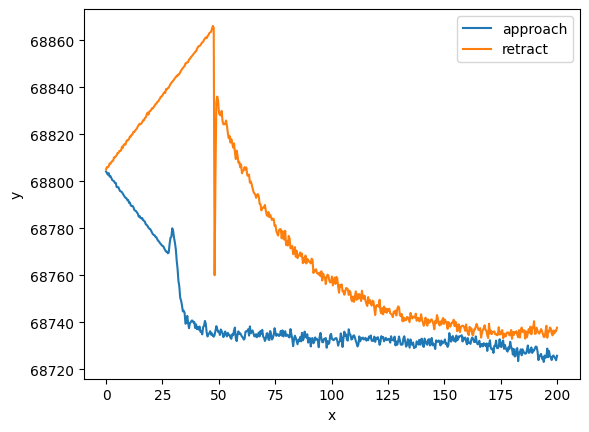

In [2]:
filepath = 'data/interdigThiols_tipSi3nN_b_0023_Excitation frequency.f.curves'
# filepath = 'data/interdigThiolsHeated_tipNweSi3nN_a_0031_Excitation frequency.f.stp'
test_data = wsxm_readcurves(filepath)
print(test_data.keys())
test_chan = 'Excitation frequency' #'Normal force', 'Amplitude', 'Excitation frequency', 'Phase'
curv_num = 1
print(test_data[test_chan]['curves'][curv_num]['data'].keys())

spectro_data = test_data[test_chan]['curves'][curv_num]['data']
test_spectro, test_param = wsxm_calcspectroparam(spectro_data, test_chan)
# print(test_param)
fig, ax = plt.subplots()
sns.lineplot(data=test_spectro, x="x", y="y", hue="segment", ax=ax)
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=handles, labels=labels) #remove legend title

#show calculations in plot for checking
# plt.hlines(test_param['Adhesion']['zero'], test_spectro['x'].min(), 
#            test_spectro['x'].max(), linestyles='dashed', colors='r')
# plt.hlines(test_param['Adhesion']['min'], test_spectro['x'].min(), 
#            test_spectro['x'].max(), linestyles='dashed', colors='r')
# plt.plot(test_param['Snap-in distance']['x'], test_param['Snap-in distance']['y'],
#          'r', linestyle='solid',linewidth=2)
# plt.plot(test_param['Stiffness']['x'], test_param['Stiffness']['y'],
#          'r', linestyle='solid',linewidth=2)

plt.show()
# test_data[test_chan]['curves'][curv_num]['header']
# print(test_spectro.max())
# test_spectro

1 interdigThiols_tipSi3nN_b_0030.b.dy.top
2 interdigThiols_tipSi3nN_b_0030.f.dy.ch1
3 interdigThiols_tipSi3nN_b_0030.b.dy.ch12
4 interdigThiols_tipSi3nN_b_0030.f.dy.ch15
5 interdigThiols_tipSi3nN_b_0030.b.dy.ch15
6 interdigThiols_tipSi3nN_b_0030.f.dy.ch12
7 interdigThiols_tipSi3nN_b_0030.b.dy.ch1
8 interdigThiols_tipSi3nN_b_0030.f.dy.top


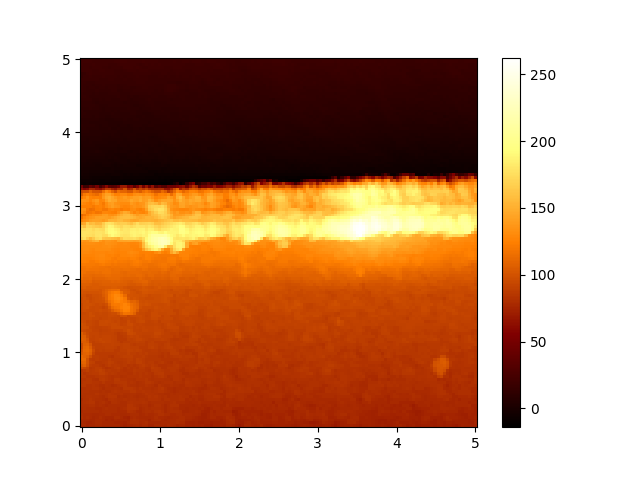

-14.062525423728813 262.5004745762712


In [25]:
# plt.close()
filepath = 'data/interdigThiols_tipSi3nN_b_0030.b.dy.top'
test_data = wsxm_readchan(filepath, all_files=True)
test_chan = 'Topography'#'Topography', 'Normal force', 'Excitation frequency', 'Amplitude'
test_dir = 'Backward'
im_data_test = test_data[test_chan][test_dir]
# xx = im_data_test['X'].reshape(128,128)
# yy = im_data_test['Y'].reshape(128,128)
# zz = im_data_test['Z'].reshape(128,128)
xx, yy, zz = get_imgdata(im_data_test)
plt.pcolormesh(xx,yy,zz, cmap='afmhot')
plt.colorbar()
plt.show()
print(zz.min(), zz.max())
# test_data.keys()
# test_data[test_chan][test_dir]['header']

-65.82043713017751 198.24256286982248 264.063


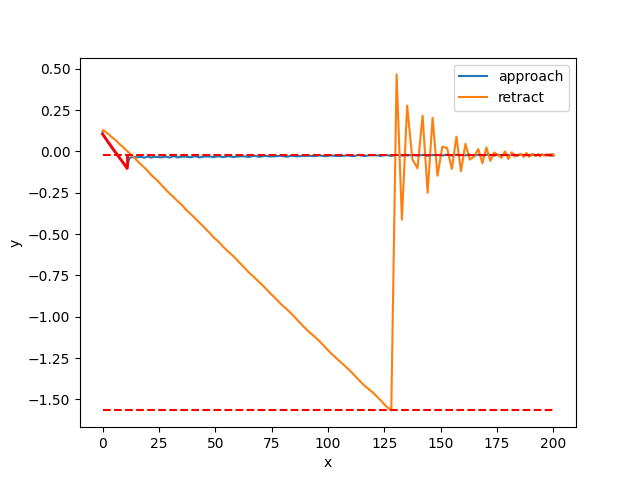

TypeError: descriptor 'remove' for 'list' objects doesn't apply to a 'str' object

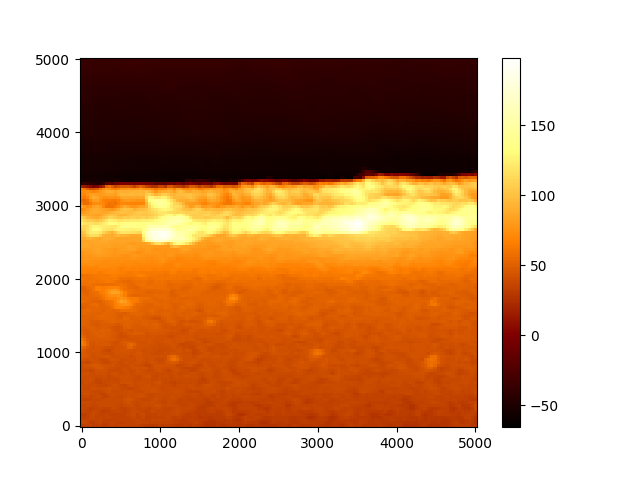

In [7]:
channel = 'Topography' #'Excitation frequency', 'Normal force', 'Amplitude', 'Topography'
chan_dir = 'Image Forward with Backward Ramps' #'Image Forward with Forward Ramps', 'Image Backward with Backward Ramps', 'Image Backward with Forward Ramps', 'Image Forward with Backward Ramps'
img_dir = chan_dir.split(' ')[1]
data_dict_chan = data_dict[channel][chan_dir]
# im_data = data_dict_chan['data']
header_dict = data_dict_chan['header']
x_num = int(header_dict['Number of rows'])
y_num = int(header_dict['Number of rows'])
chan_list = data_dict.keys()

pt_x, pt_y, pt_z = 1, 120, 0
style = 'XY'

# test_data = wsxm_readcurves(filepath)
#plot AFM Z image
# im_data = test_data['Channel']['data']
xx, yy, zz = get_imgdata(data_dict_chan, style, pt_x, pt_y, pt_z) #im_data['X'].reshape(128,128)
# yy = im_data['Y'].reshape(128,128)
# zz = data_dict_chan['data']['Z'] #im_data['Z'].reshape(128,128)
# zz = data_dict_chan['data']['ZZ'][pt_z,:,:]#1st index:xy sections, 2nd index:xz sections, 3rd index: yz sections

#TODO: change and check how forward backward in z (or x) can be consistently plotted
print(zz.min(),zz.max(), zz.max()-zz.min())
plt.figure()
plt.pcolormesh(xx,yy,zz, cmap='afmhot')
plt.colorbar()

# if header_dict['Spectroscopy direction'] == 'Forward': #CHECK THIS
#     segment
#obtain and plot spectroscopy data
chan_spectro = 'Normal force'
# spec_params = ['Adhesion', 'Snap-in distance', 'Stiffness'] #check keys of FUNC_DICT
#CHECK x and y in all functions!!!
spectro_data = wsxm_getspectro(data_dict, channel=chan_spectro,
                               img_dir=img_dir, x=pt_x, y=pt_y)
df_spectro, data_param = wsxm_calcspectroparam(spectro_data, chan_spectro)

# print(fd)
fig, ax = plt.subplots()
sns.lineplot(data=df_spectro, x="x", y="y", hue="segment", ax=ax)
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=handles, labels=labels) #remove legend title

#show calculations in plot for checking
plt.hlines(data_param['Adhesion']['zero'], df_spectro['x'].min(), 
           df_spectro['x'].max(), linestyles='dashed', colors='r')
plt.hlines(data_param['Adhesion']['min'], df_spectro['x'].min(), 
           df_spectro['x'].max(), linestyles='dashed', colors='r')
plt.plot(data_param['Snap-in distance']['x'], data_param['Snap-in distance']['y'],
         'r', linestyle='solid',linewidth=2)
plt.plot(data_param['Stiffness']['x'], data_param['Stiffness']['y'],
         'r', linestyle='solid',linewidth=2)
# acq_pt = test_data['Curves'][3]['header']['Acquisition point'].strip('()').split(',')
# plt.scatter(float(acq_pt[0]), float(acq_pt[1]),color = 'green')
plt.show()
# header_dict
# #plot Curves
# test_df = pd.DataFrame.from_dict(test_data['Curves'][3]['data'])
# sns.lineplot(data=test_df, x="Z", y="Excitation frequency", hue="Segment")
# plt.show()

# spec_params = ['Adhesion', 'Snap-in distance', 'Stiffness'] #check keys of FUNC_DICT
img_specparams = calc_spectro_prop(data_dict, chan_spectro, img_dir)
img_adh = img_specparams['Snap-in distance']
plt.pcolormesh(xx,yy,img_adh, cmap='afmhot',vmin=None, vmax=0.08)
plt.colorbar()
#plot histogram of parameter
plt.figure()
sns.histplot(img_adh.flatten(),binrange=(0,0.08))
plt.show()
# header_dict

In [6]:
128*128

16384

{'Image header size': '3031', 'Angle': '0', 'Set Point': '-9 V', 'Signal Gain': '1', 'Topography Bias': '0 mV', 'X Amplitude': '1 nm', 'X Offset': '0 nm', 'X-Frequency': '58.594 Hz', 'XY Gain': '0.0588235', 'Y Amplitude': '1 nm', 'Y Offset': '-451.813 nm', 'Z Gain': '10', 'Z Offset': '0 nm', 'Amplitude': '1e-006 V', 'Bandwidth': '445.626', 'Filter Out': '8079 Hz', 'Frq. Scan Sensitivity': '0.024 kHz/V', 'Gain in': '100', 'Gain out X': '2', 'Gain out Y': '2', 'Phase': '52.9998 Deg', 'Quality factor (Q)': '171.177', 'Resonance frequency': '72293.6 Hz', 'Input channel': 'Amplitude', 'Integral': '2.5', 'Proportional': '10', 'Tilt X': '0 nm/nm', 'Tilt Y': '0 nm/nm', 'Acquisition channel': 'Amplitude', 'Acquisition primary channel': 'Channel 15', 'Channel is inverted': 'No', 'Conversion Factor 00': '10 nm', 'Conversion Offset 00': '0 nm', 'Force constant': '165.73 N/m', 'Head type': 'AFM', 'Image Data Type': 'short', 'Number of columns': '128', 'Number of rows': '128', 'Round percent': '10',

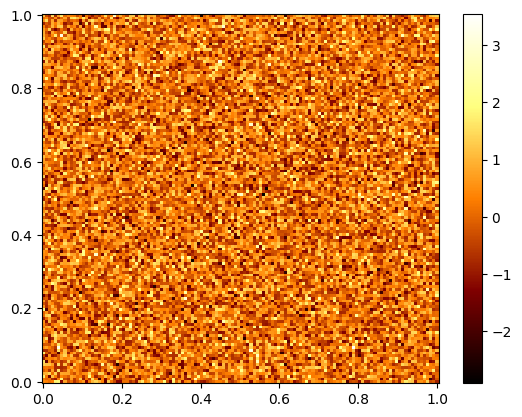

{'Image header size': '3037', 'Angle': '0', 'Set Point': '-9 V', 'Signal Gain': '1', 'Topography Bias': '0 mV', 'X Amplitude': '1 nm', 'X Offset': '0 nm', 'X-Frequency': '58.594 Hz', 'XY Gain': '0.0588235', 'Y Amplitude': '1 nm', 'Y Offset': '-451.813 nm', 'Z Gain': '10', 'Z Offset': '0 nm', 'Amplitude': '1e-006 V', 'Bandwidth': '445.626', 'Filter Out': '8079 Hz', 'Frq. Scan Sensitivity': '0.024 kHz/V', 'Gain in': '100', 'Gain out X': '2', 'Gain out Y': '2', 'Phase': '52.9998 Deg', 'Quality factor (Q)': '171.177', 'Resonance frequency': '72293.6 Hz', 'Input channel': 'Amplitude', 'Integral': '2.5', 'Proportional': '10', 'Tilt X': '0 nm/nm', 'Tilt Y': '0 nm/nm', 'Acquisition channel': 'Amplitude', 'Acquisition primary channel': 'Channel 15', 'Channel is inverted': 'No', 'Conversion Factor 00': '10 nm', 'Conversion Offset 00': '0 nm', 'Force constant': '165.73 N/m', 'Head type': 'AFM', 'Image Data Type': 'short', 'Number of columns': '128', 'Number of rows': '128', 'Round percent': '10',

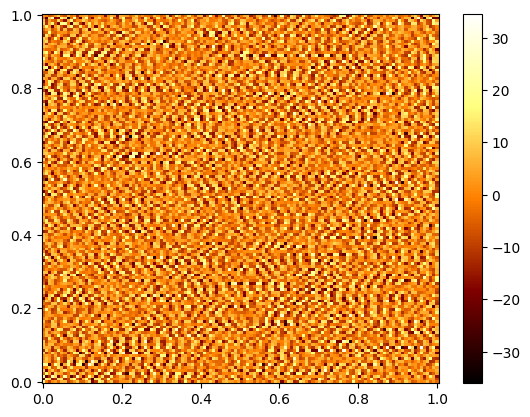

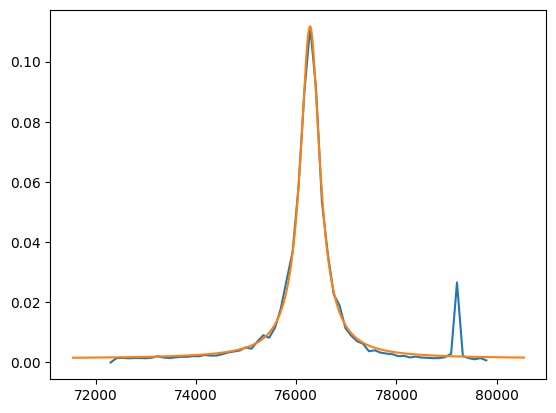

{'offset': 0.0012934139192533319, 'resonance freq': 76274.15433510602, 'fwhm': 473.8767061692985, 'area': 82.11451304229297, 'Q factor': 160.9578047245397}


In [2]:
files = ['data/20240202_laser_off_128pts_58lps_0002.f.dy.ch15', 
         'data/20240202_laser_on_128pts_58lps_0003.f.dy.ch15']
data_dict = {}
rms_min = np.inf
for file in files:
    data_dict[file] = {}
    data_dict[file]['Frequency'], data_dict[file]['PSD'], data_dict[file]['Z rms'] = get_psd(file)
    if data_dict[file]['Z rms'] < rms_min:
        rms_min = data_dict[file]['Z rms']
        off_file = file

on_file = [n for n in files if n != off_file][0]
data_dict[off_file]['Label'] = 'Laser ON'
data_dict[on_file]['Label'] = 'Laser OFF'

#plot data images
# for file in files:
#     plt.plot(data_dict[file]['Frequency'], data_dict[file]['PSD'], label = data_dict[file]['PSD'])
# plt.show()
    

#z_pow = 2*(z_fftx_avg[64:]**2)/(15000*128)
#freq_drive = float(head_data['Resonance frequency'].split(' ')[0])
#freq_array_real = freq_array_shift[64:] + freq_drive
freq_final = data_dict[on_file]['Frequency']
psd_final = data_dict[on_file]['PSD'] - data_dict[off_file]['PSD']
plt.plot(freq_final, psd_final)
#plt.show()

#guess = [0, 76000, 2000, 100000]
y_guess = psd_final.min()
f_guess = freq_final[psd_final.argmax()]
w_guess = 2*np.abs(freq_final[(np.abs(psd_final - psd_final.max()/2)).argmin()]-f_guess)
A_guess = np.pi*w_guess*psd_final.max()/2
guess = [y_guess, f_guess, w_guess, A_guess] #y0,f0,w,A
#fit
popt, pcov = curve_fit(lorentzian, freq_final,psd_final,
                    p0=guess, bounds=(0,np.inf))
#print(np.linalg.cond(pcov))
params = ['offset','resonance freq', 'fwhm', 'area']
fit_dict = dict(zip(params, popt))
fit_dict['Q factor'] = fit_dict['resonance freq']/fit_dict['fwhm']

#plot fit
f_min, f_max = freq_final.min(), freq_final.max()
f_ext = 0.1*(f_max-f_min)
freq_fit_range = np.linspace(f_min-f_ext, f_max+f_ext, 100000)
plt.plot(freq_fit_range,lorentzian(freq_fit_range, *popt))
plt.show()

print(fit_dict)

In [37]:
# Q = head_data['Quality factor (Q)']
k_cant = 2 # N/m
T = 300 #K
kb = 1.380649e-23 #J/K
V_rms = np.sqrt(fit_dict['area'])
corr_fac = 4/3 #Butt-Jaschke correction for thermal noise
sens = np.sqrt(corr_fac*kb*T/k_cant)/V_rms/1e-9 #nm/V 
print(V_rms, sens)
print(np.sqrt(data_dict[on_file]['Z rms']**2 - data_dict[off_file]['Z rms']**2))
# z = im_data['Z']
# print(np.sqrt(z.dot(z)/z.size))

9.061705857193388 0.005798914136715741
9.421556156513725


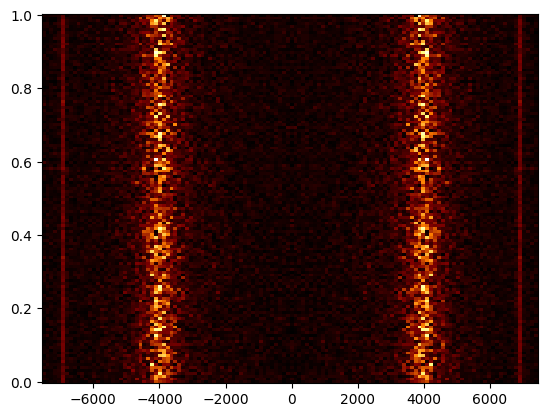

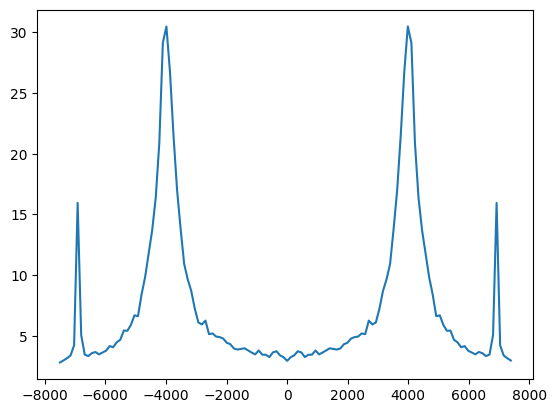

In [6]:
# #1D Fourier Transform of image and average along Y axis.
# z_fftx = np.abs(np.fft.fft(zz))
# z_fftx_shift = np.fft.fftshift(z_fftx)
# z_fftx_avg = np.average(z_fftx_shift, axis=0)

# num_pts = len(z_fftx_avg)
# sample_rate = 2*num_pts*float(head_data['X-Frequency'].split(' ')[0])
# freq_array = np.fft.fftfreq(len(z_fftx_avg), 1 / sample_rate)
# freq_array_shift = np.fft.fftshift(freq_array)
# ff, _ = np.meshgrid(freq_array_shift, freq_array_shift)
# plt.pcolormesh(ff, yy, z_fftx_shift, cmap='afmhot')
# plt.show()
# plt.plot(freq_array_shift, z_fftx_avg)
# plt.show()